### Model 3. Prices only (po) model based LSTM - Long Short Term Memory.

Univariate version of LSTM model. Same data, same specs of the model, but for LSTM. 

Making necessary imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# from scipy import stats

Defining the list of companies to predict the stock price for. (Temporarily narrowed down to one stock for testing of the model)

In [6]:
tickers = ['aapl'                                                                                       # stock from Fin. statements dataset
 , 'msft', 'aig', 'pcg', 'mcd', 'bcs', 'nvda', 'intc', 'amzn']                                           # stocks from Fin. statements dataset

Reading csv files with stock price data, converting date to datetime, cleaning from unneeded columns.

In [8]:
stock_dfs = {}
for t in tickers:
    # read csv files
    stock_dfs[t]=pd.read_csv(f'../data/clean_csv/{t}_p_fs.csv')
    # convert date to datetime
    stock_dfs[t]["Date"] = pd.to_datetime(stock_dfs[t]["Date"])
    # Drop irrelevant columns
    stock_dfs[t].drop(columns=['Unnamed: 0', 'OpenInt', 'Open', 'High', 'Low'],inplace=True)
    # Set 'Date' as index
    stock_dfs[t].set_index('Date', inplace=True)
    # Resample to quarterly data and keep the last price in each quarter
    stock_dfs[t] = stock_dfs[t].resample('ME').last()

    # Reset index to make 'Date' a column again
    stock_dfs[t].reset_index(inplace=True)

    print(f'{t}')
    print(stock_dfs[t].shape)

aapl
(98, 24)
msft
(101, 24)
aig
(94, 24)
pcg
(94, 24)
mcd
(94, 24)
bcs
(94, 24)
nvda
(92, 24)
intc
(94, 24)
amzn
(95, 24)


Splitting the data into train and test. Cannot do it without train_test_split function, as it does not maintain the sequence of data, because of it's randomization parameter. 

In [10]:
train_dfs = {}
test_dfs = {}

for t in tickers:
    
    # Train-test split manually
    len_data = len(stock_dfs[t])     #Count of rows that data has
    len_train = round(len_data * 0.75)   # %75 train + %25 test
    len_test = len_data - len_train
   
    print(f'Total rows: {len_data}; Train rows: {len_train}; Test rows: {len_test}.')

    train_dfs[t] = stock_dfs[t][:len_train]
    test_dfs[t] = stock_dfs[t][len_train:]
    # printing to show that train and test dfs do not intersect
    print(t)
    print(train_dfs[t].tail(2))
    print(test_dfs[t].head(2))

Total rows: 98; Train rows: 74; Test rows: 24.
aapl
         Date   Close    Volume  C_returns  Market Cap(in B USD)   Revenue  \
72 2015-10-31  114.56  51494522  -0.008482                586.86  233715.0   
73 2015-11-30  113.90  40696103   0.004321                586.86  233715.0   

    Gross Profit  Net Income  Earning Per Share   EBITDA  ...  Current Ratio  \
72       93626.0     53394.0              2.305  82487.0  ...         1.1088   
73       93626.0     53394.0              2.305  82487.0  ...         1.1088   

    Debt/Equity Ratio      ROE      ROA      ROI  Net Profit Margin  \
72              0.539  44.7355  18.3899  30.9201            22.8458   
73              0.539  44.7355  18.3899  30.9201            22.8458   

    Free Cash Flow per Share  Return on Tangible Equity  Number of Employees  \
72                    0.9743                    48.3878             110000.0   
73                    0.9743                    48.3878             110000.0   

    Inflation Rat

Reshaping the datasets for the model

In [12]:
train_datasets = {}
test_datasets = {}

# Creating datasets and shaping their form for the model.
for t in tickers:
    train_datasets[t] = train_dfs[t]['Close'].values
    train_datasets[t] = np.reshape(train_datasets[t], (-1, 1))

    test_datasets[t] = test_dfs[t]['Close'].values
    test_datasets[t] = np.reshape(test_datasets[t], (-1, 1))

Scaling train data. Applying lookback window. Reshaping for model.

In [14]:
train_datasets_scaled = {}
scales = {}

X_trains = {}
y_trains = {}

Lookback = 12

for t in tickers:
    # Scaling train Dataset
    scales[t] = MinMaxScaler(feature_range = (0,1))
    train_datasets_scaled[t] = scales[t].fit_transform(train_datasets[t])
    X_trains[t] = []
    y_trains[t] = []
    len_train = len(train_datasets_scaled[t])

    # Creating a moving window of size Lookback for the forecast
    for i in range(Lookback, len_train):
        X_trains[t].append(train_datasets_scaled[t][i - Lookback:i, 0])
        y_trains[t].append(train_datasets_scaled[t][i, 0])

    # Converting to Numpy array and reshaping for model
    X_trains[t], y_trains[t] = np.array(X_trains[t]), np.array(y_trains[t])
    X_trains[t] = np.reshape(X_trains[t], (X_trains[t].shape[0], X_trains[t].shape[1],1))
    y_trains[t] = np.reshape(y_trains[t], (y_trains[t].shape[0],1))
    print("Shape of X_trains:",X_trains[t].shape)
    print("Shape of y_trains:",y_trains[t].shape)
    

Shape of X_trains: (62, 12, 1)
Shape of y_trains: (62, 1)
Shape of X_trains: (64, 12, 1)
Shape of y_trains: (64, 1)
Shape of X_trains: (58, 12, 1)
Shape of y_trains: (58, 1)
Shape of X_trains: (58, 12, 1)
Shape of y_trains: (58, 1)
Shape of X_trains: (58, 12, 1)
Shape of y_trains: (58, 1)
Shape of X_trains: (58, 12, 1)
Shape of y_trains: (58, 1)
Shape of X_trains: (57, 12, 1)
Shape of y_trains: (57, 1)
Shape of X_trains: (58, 12, 1)
Shape of y_trains: (58, 1)
Shape of X_trains: (59, 12, 1)
Shape of y_trains: (59, 1)


In [15]:
test_datasets_scaled = {}
test_scales = {}

X_tests = {}
y_tests = {}

for t in tickers:
    # Scaling test Dataset
    test_scales[t] = MinMaxScaler(feature_range = (0,1))
    test_datasets_scaled[t] = test_scales[t].fit_transform(test_datasets[t])
    X_tests[t] = []
    y_tests[t] = []
    len_test = len(test_datasets_scaled[t])

    # Creating a moving window of size Lookback for the forecast
    for i in range(Lookback, len_test):
        X_tests[t].append(test_datasets_scaled[t][i - Lookback:i, 0])
        y_tests[t].append(test_datasets_scaled[t][i, 0])

    # Converting to Numpy array and reshaping for model
    X_tests[t], y_tests[t] = np.array(X_tests[t]), np.array(y_tests[t])
    X_tests[t] = np.reshape(X_tests[t], (X_tests[t].shape[0], X_tests[t].shape[1],1))
    y_tests[t] = np.reshape(y_tests[t], (y_tests[t].shape[0],1))
    print({t})
    print("Shape of X_tests:",X_tests[t].shape)
    print("Shape of y_tests:",y_tests[t].shape)

{'aapl'}
Shape of X_tests: (12, 12, 1)
Shape of y_tests: (12, 1)
{'msft'}
Shape of X_tests: (13, 12, 1)
Shape of y_tests: (13, 1)
{'aig'}
Shape of X_tests: (12, 12, 1)
Shape of y_tests: (12, 1)
{'pcg'}
Shape of X_tests: (12, 12, 1)
Shape of y_tests: (12, 1)
{'mcd'}
Shape of X_tests: (12, 12, 1)
Shape of y_tests: (12, 1)
{'bcs'}
Shape of X_tests: (12, 12, 1)
Shape of y_tests: (12, 1)
{'nvda'}
Shape of X_tests: (11, 12, 1)
Shape of y_tests: (11, 1)
{'intc'}
Shape of X_tests: (12, 12, 1)
Shape of y_tests: (12, 1)
{'amzn'}
Shape of X_tests: (12, 12, 1)
Shape of y_tests: (12, 1)


Building the model itself.

In [17]:
models = {}
histories = {}

for t in tickers:
    # initiate RNN
    models[t] = Sequential()
    
    # adding first LSTM layer and dropout regulatization
    models[t].add(
        LSTM(units = Lookback, 
                  activation = "tanh", 
                  return_sequences = True, 
                  input_shape = (X_trains[t].shape[1],1))
                 )
    
    models[t].add(
        Dropout(0.2)
                 )
    
    
    # adding second and third LSTM layer and dropout regulatization
    
    models[t].add(
        LSTM(units = Lookback, 
                  activation = "tanh", 
                  return_sequences = True)
                 )
    
    models[t].add(
        Dropout(0.2)
                 )

    models[t].add(
        LSTM(units = Lookback, 
                  activation = "tanh", 
                  return_sequences = True)
                 )
    
    models[t].add(
        Dropout(0.2)
                 )
    
    # adding forth LSTM layer and dropout regulatization
    
    models[t].add(
        LSTM(units = Lookback)
                 )
    
    models[t].add(
        Dropout(0.2)
                 )
    
    # adding the output layer
    models[t].add(Dense(units = 1))
    
    # compiling LSTM
    models[t].compile(
        optimizer = "adam", 
        loss = "mean_squared_error",
        metrics = ["accuracy"])
    
    # fitting the LSTM
    histories[t] = models[t].fit(X_trains[t], y_trains[t], epochs = 50, batch_size = 32, verbose=0)

C:\Users\Vladimir\anaconda3\envs\ml_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


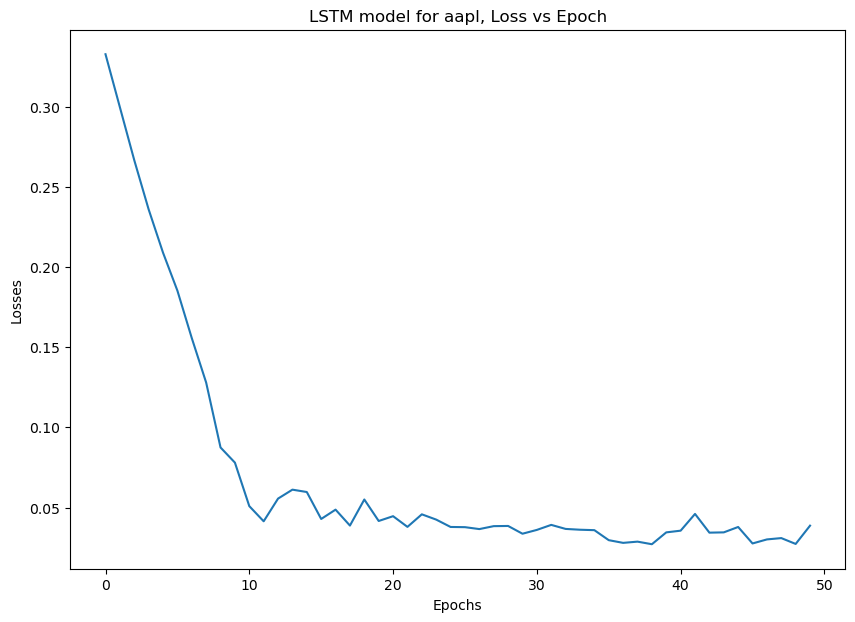

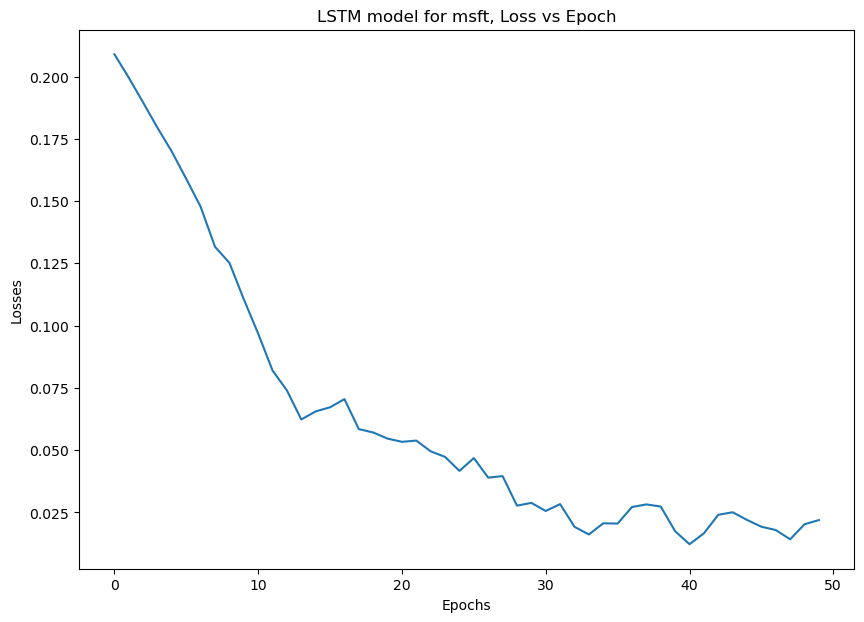

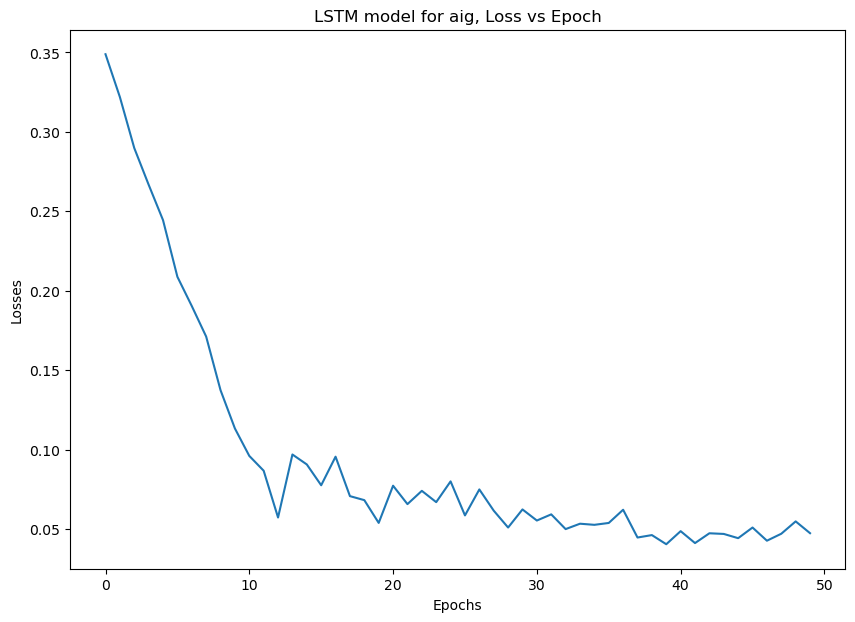

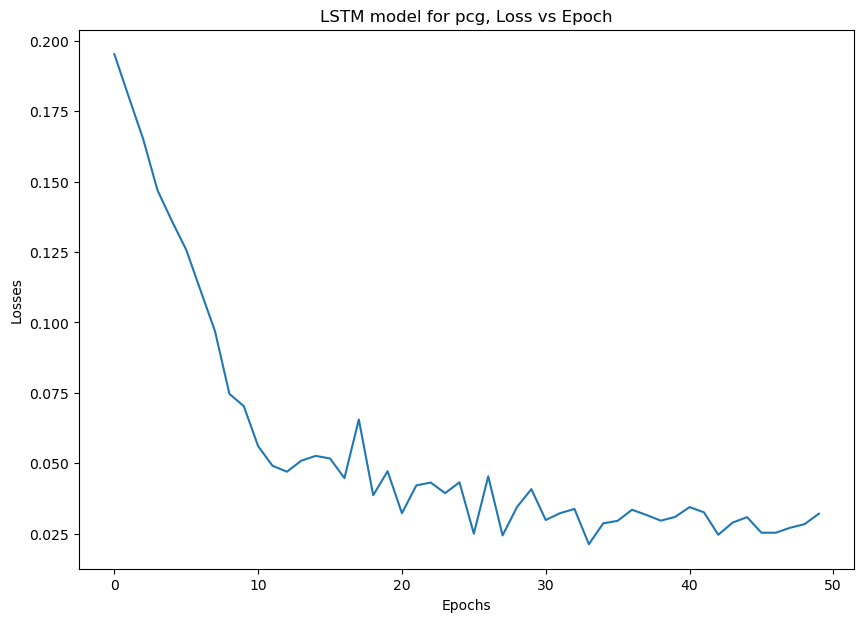

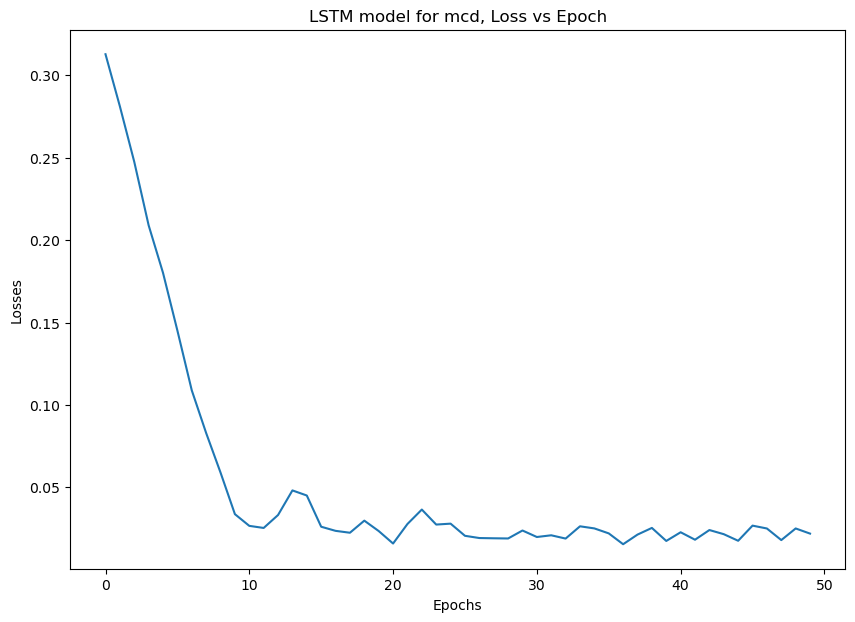

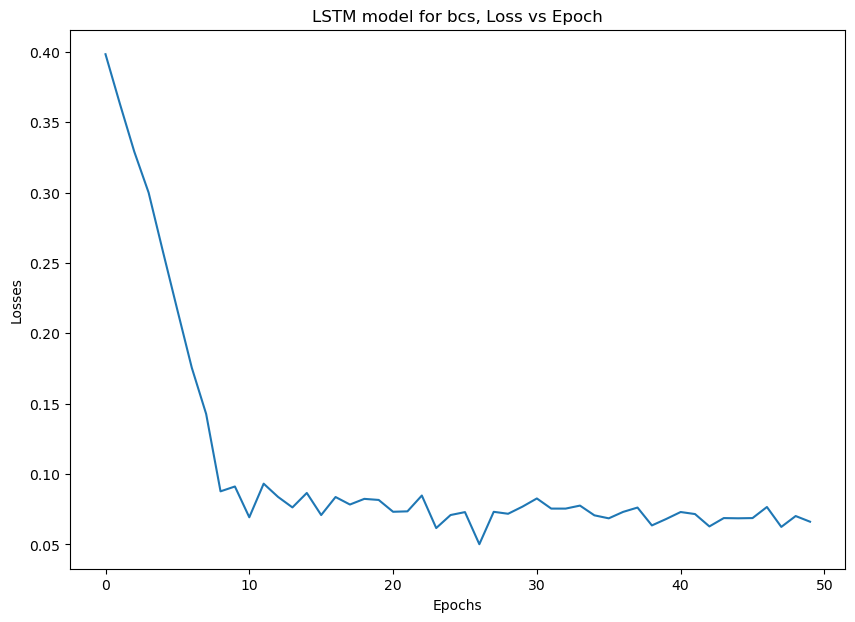

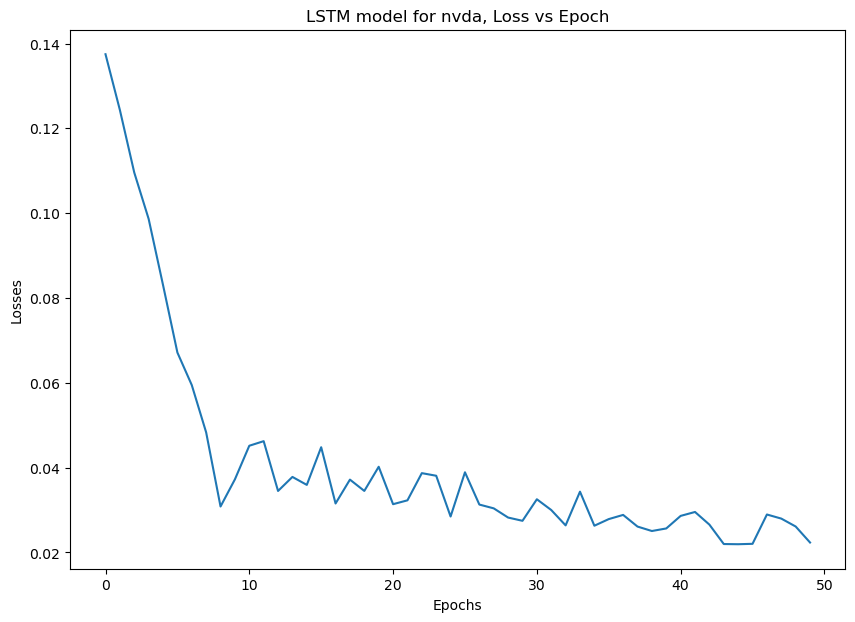

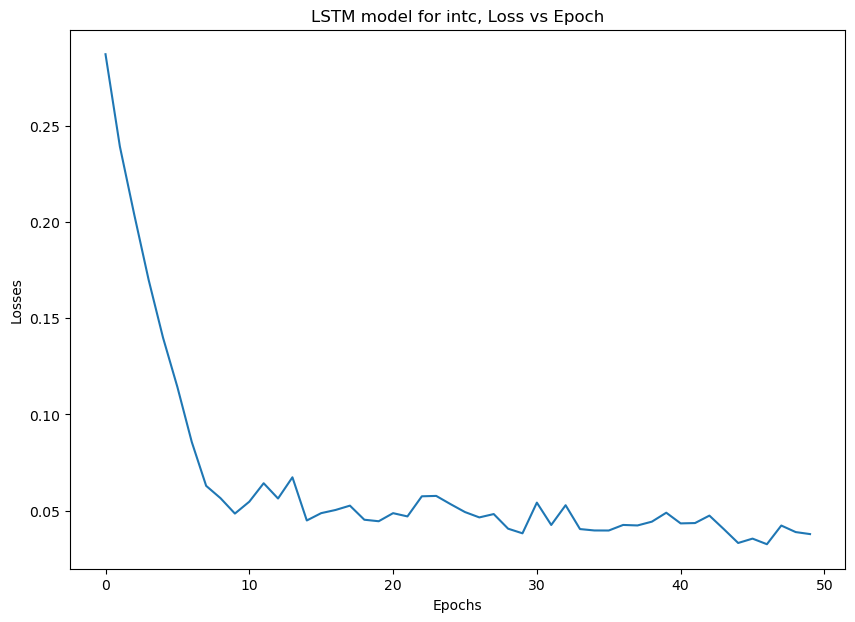

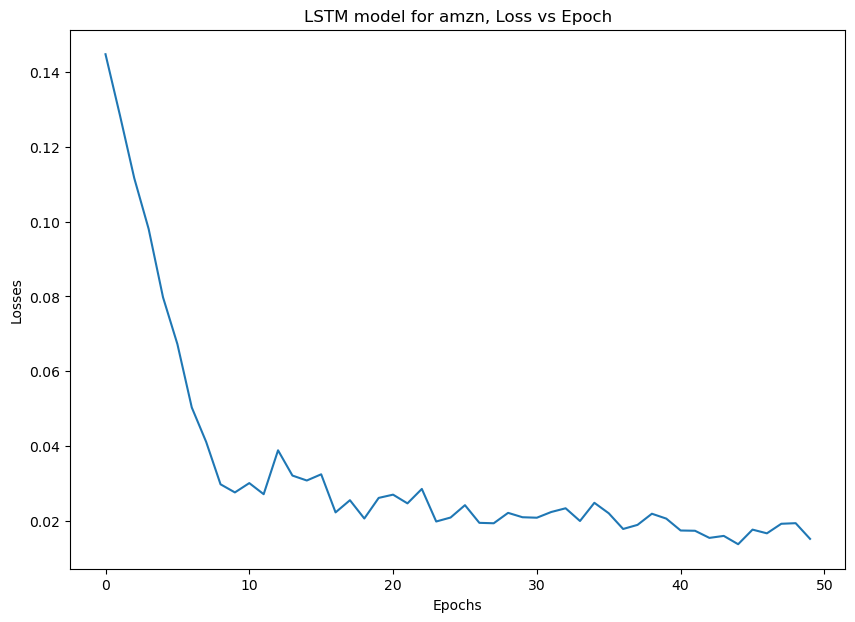

In [18]:
for t in tickers:
    # Plotting Loss vs Epochs
    plt.figure(figsize =(10,7))
    plt.plot(histories[t].history["loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Losses")
    plt.title(f"LSTM model for {t}, Loss vs Epoch")
    plt.show()

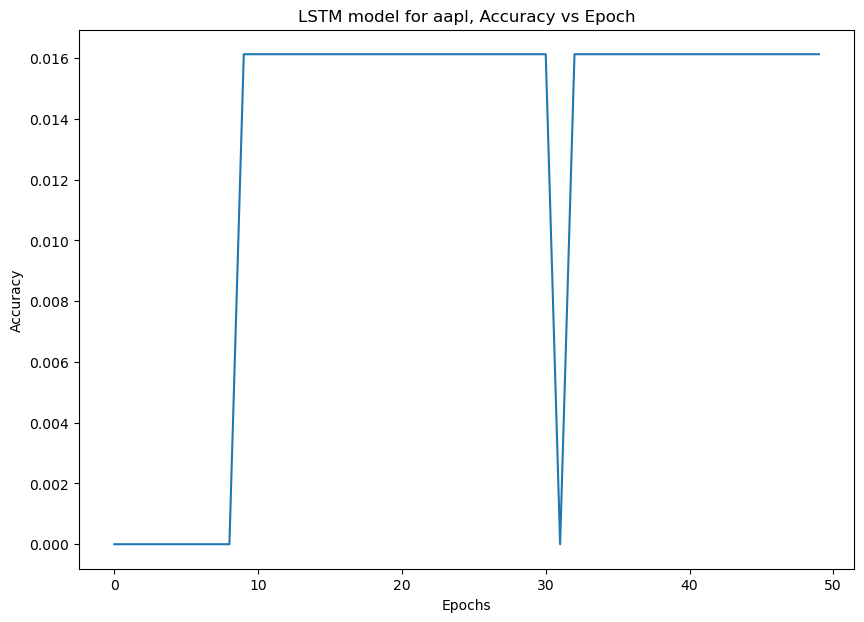

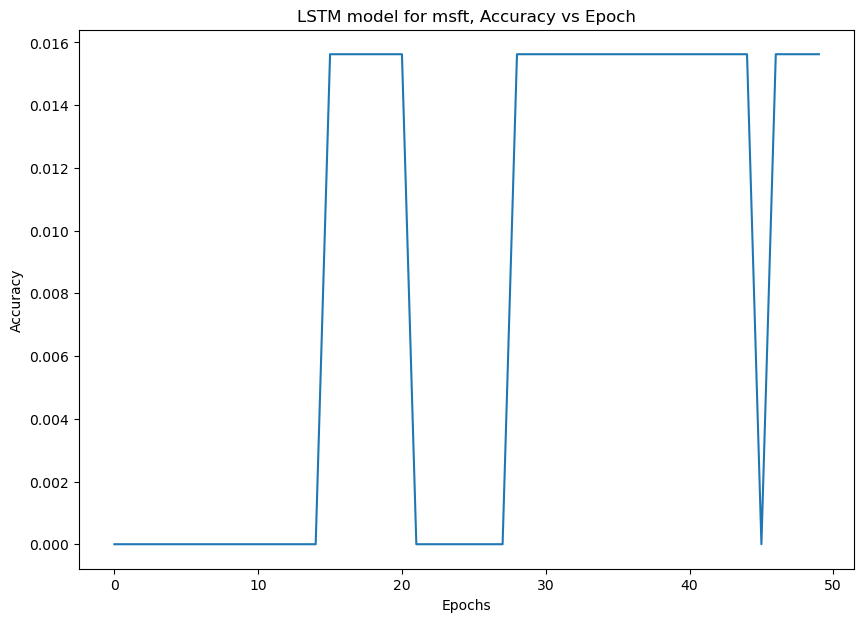

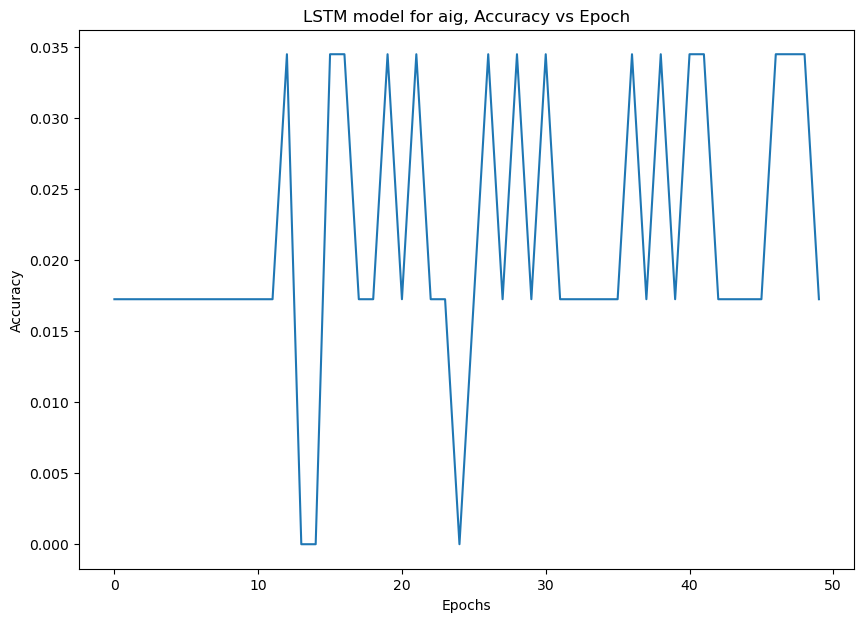

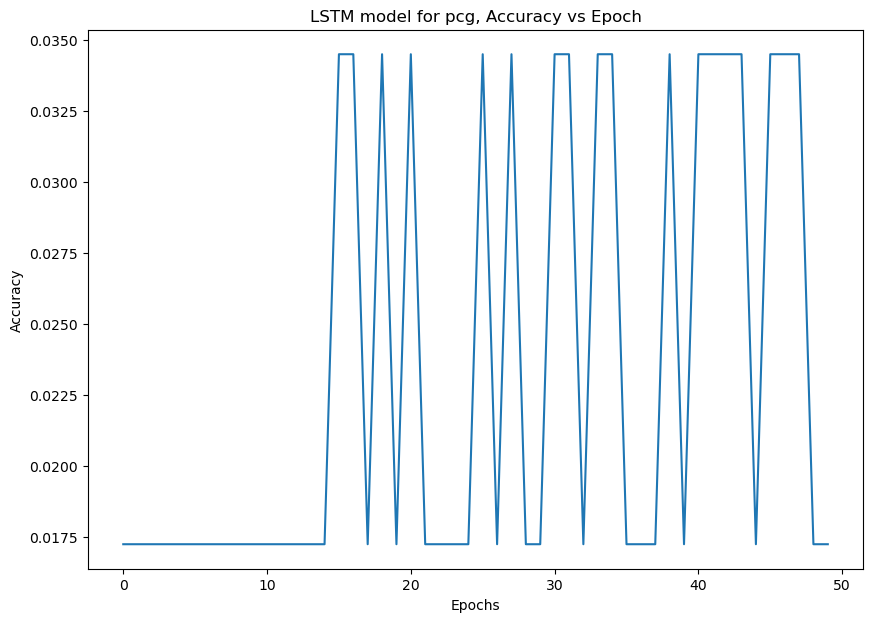

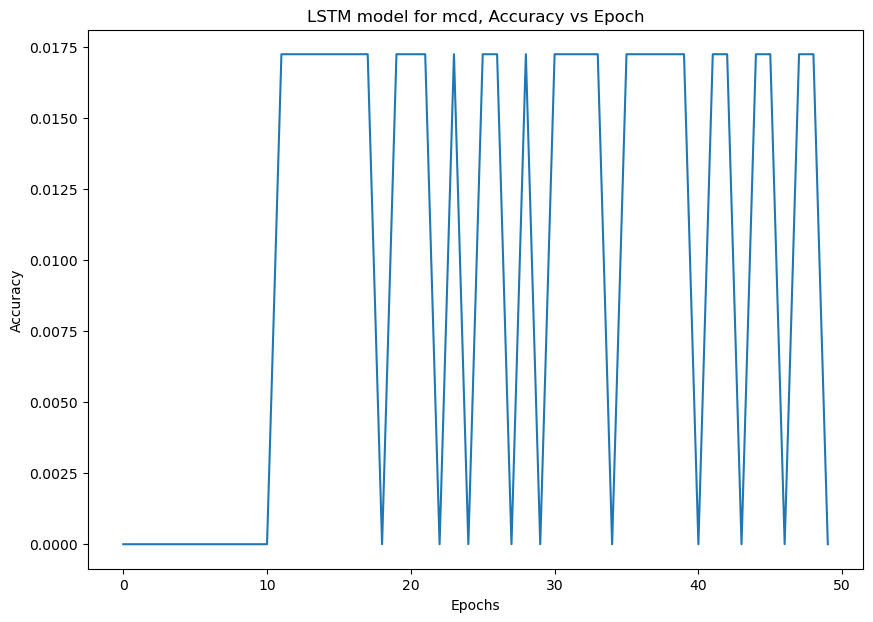

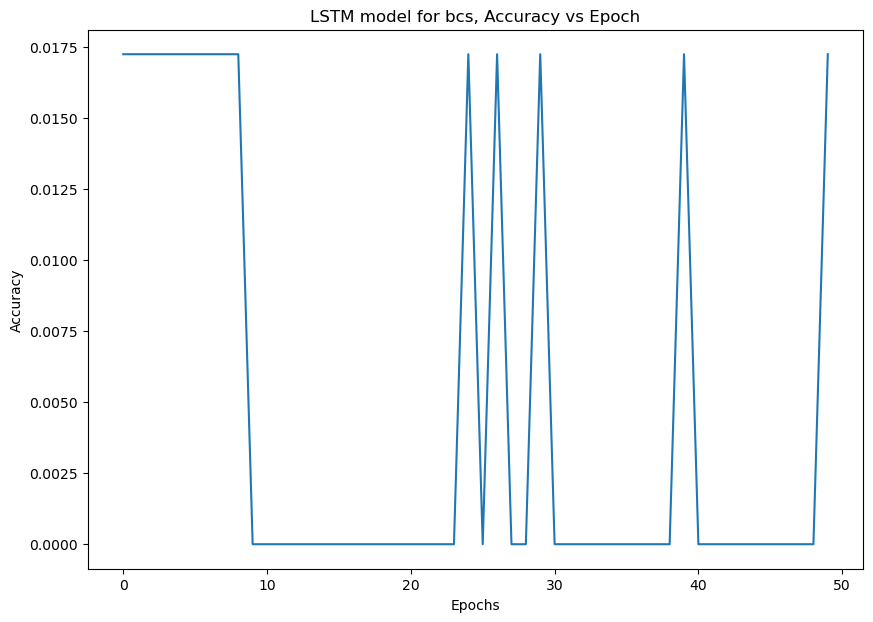

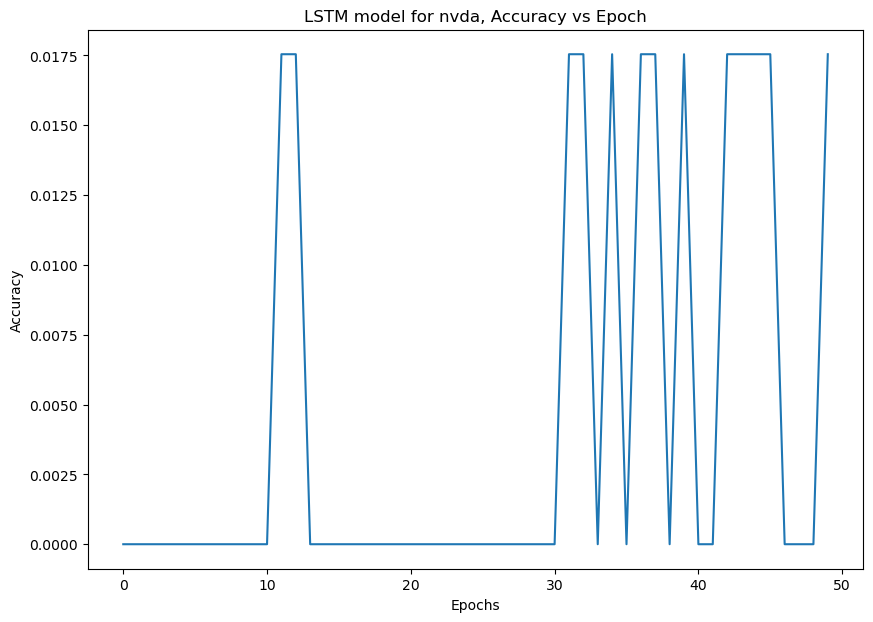

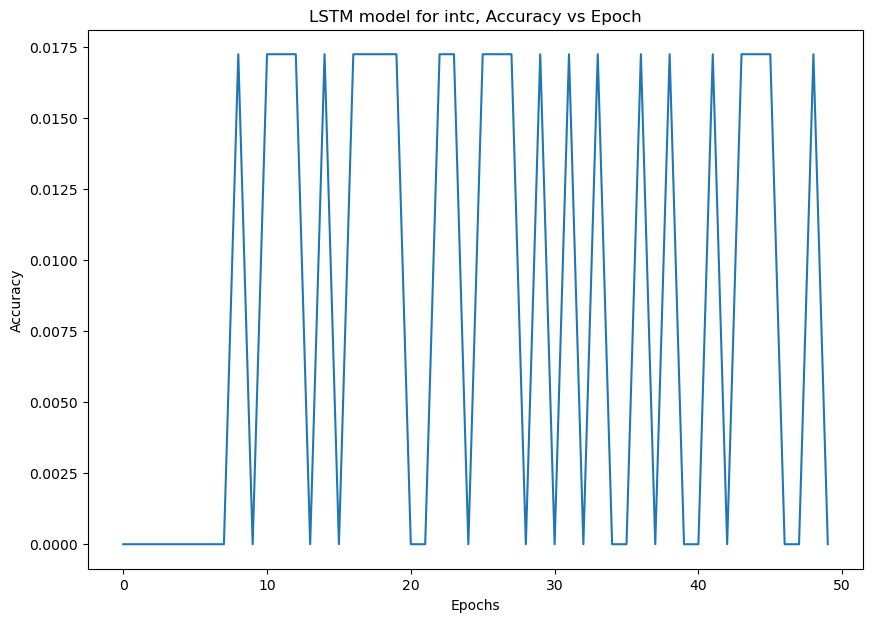

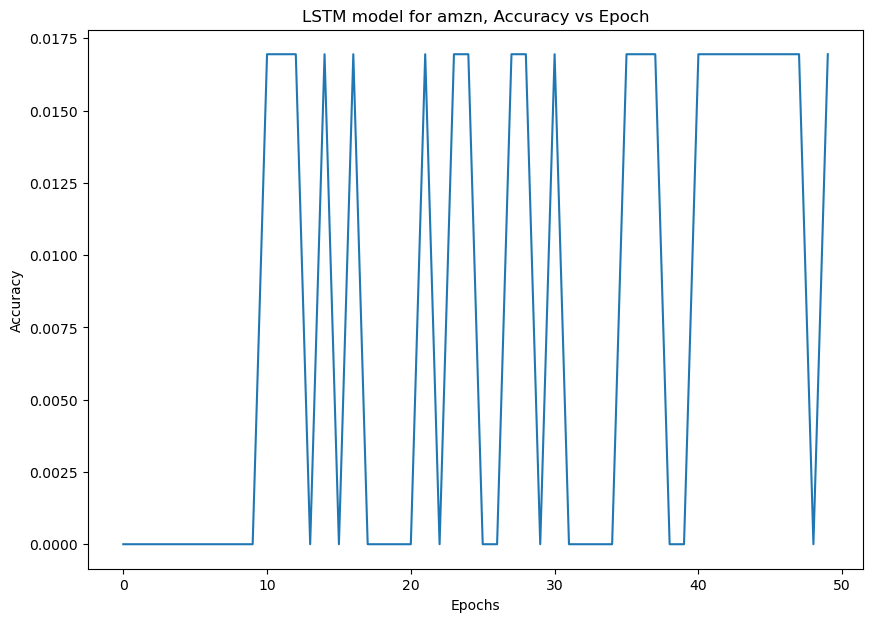

In [19]:
for t in tickers:
    # Plotting Accuracy vs Epochs
    plt.figure(figsize =(10,7))
    plt.plot(histories[t].history["accuracy"])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"LSTM model for {t}, Accuracy vs Epoch")
    plt.show()

Making train predictions. Visualizing train data and prediction.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


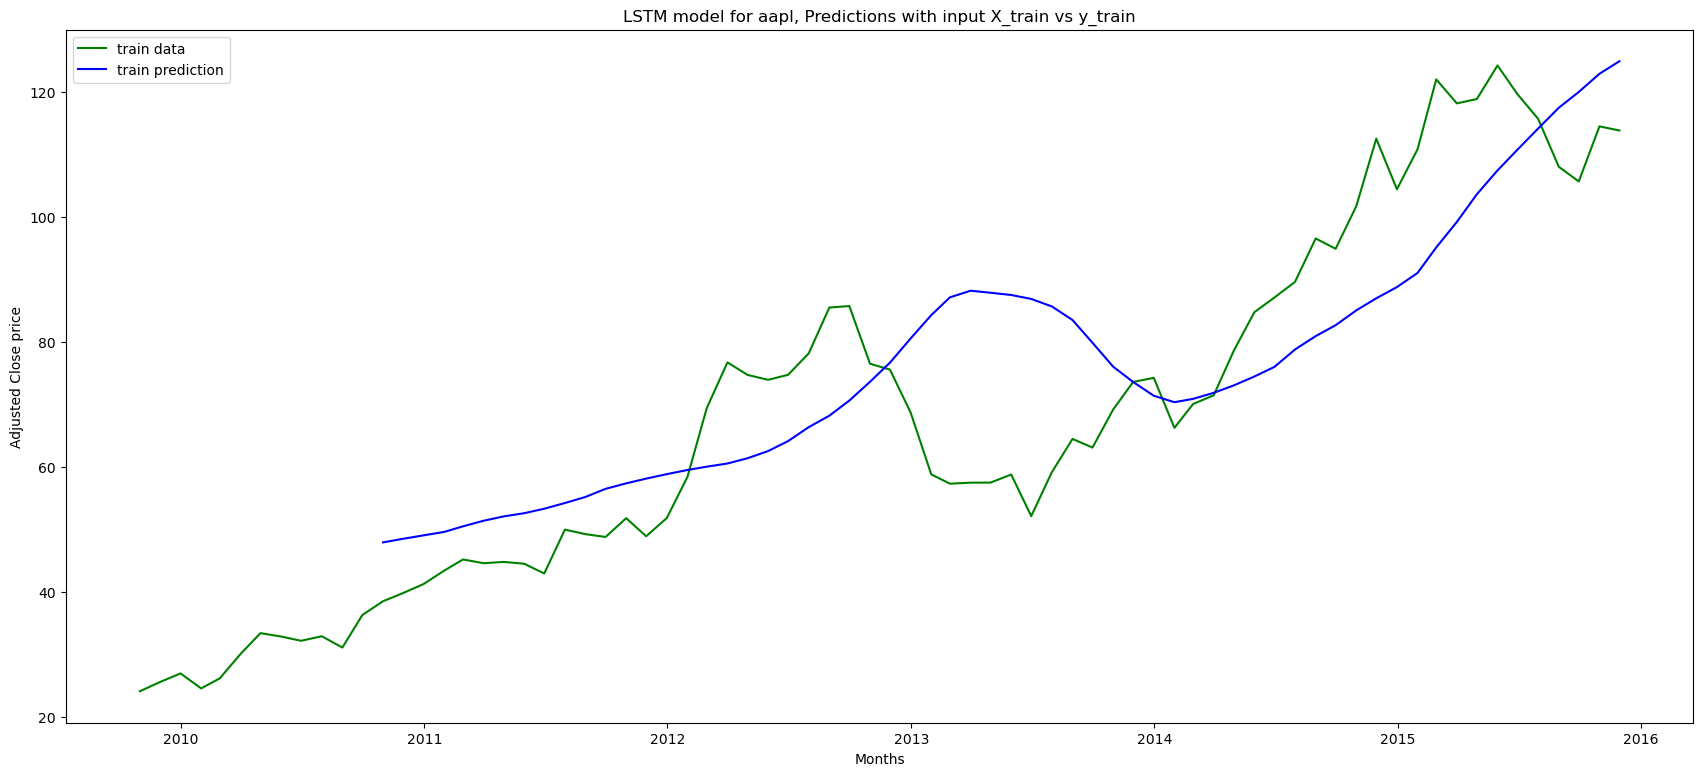

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step  


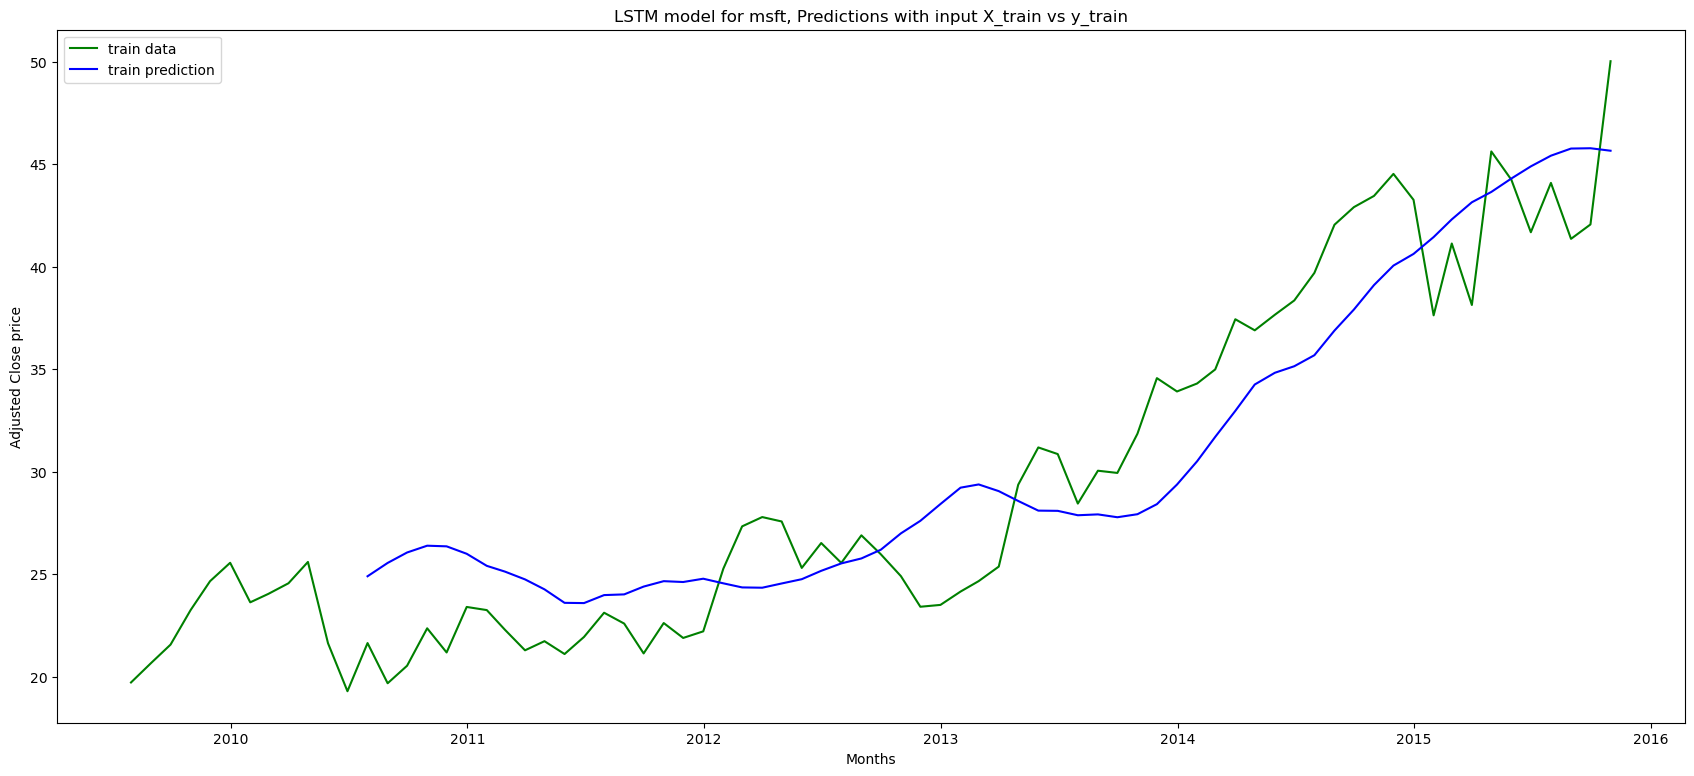

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/stepWARNING:tensorflow:5 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001A7BFADBA60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


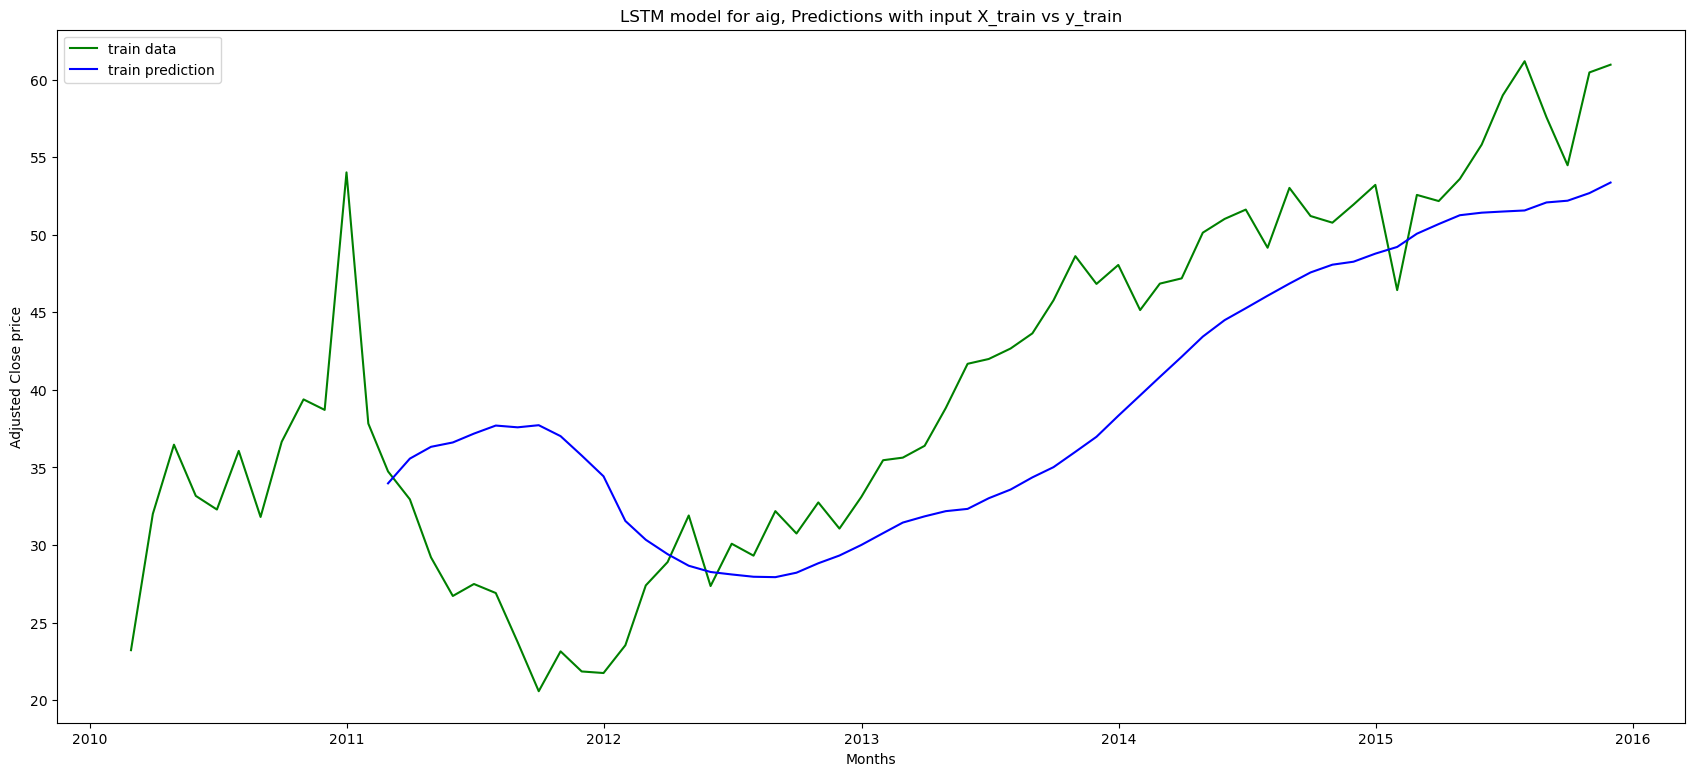

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


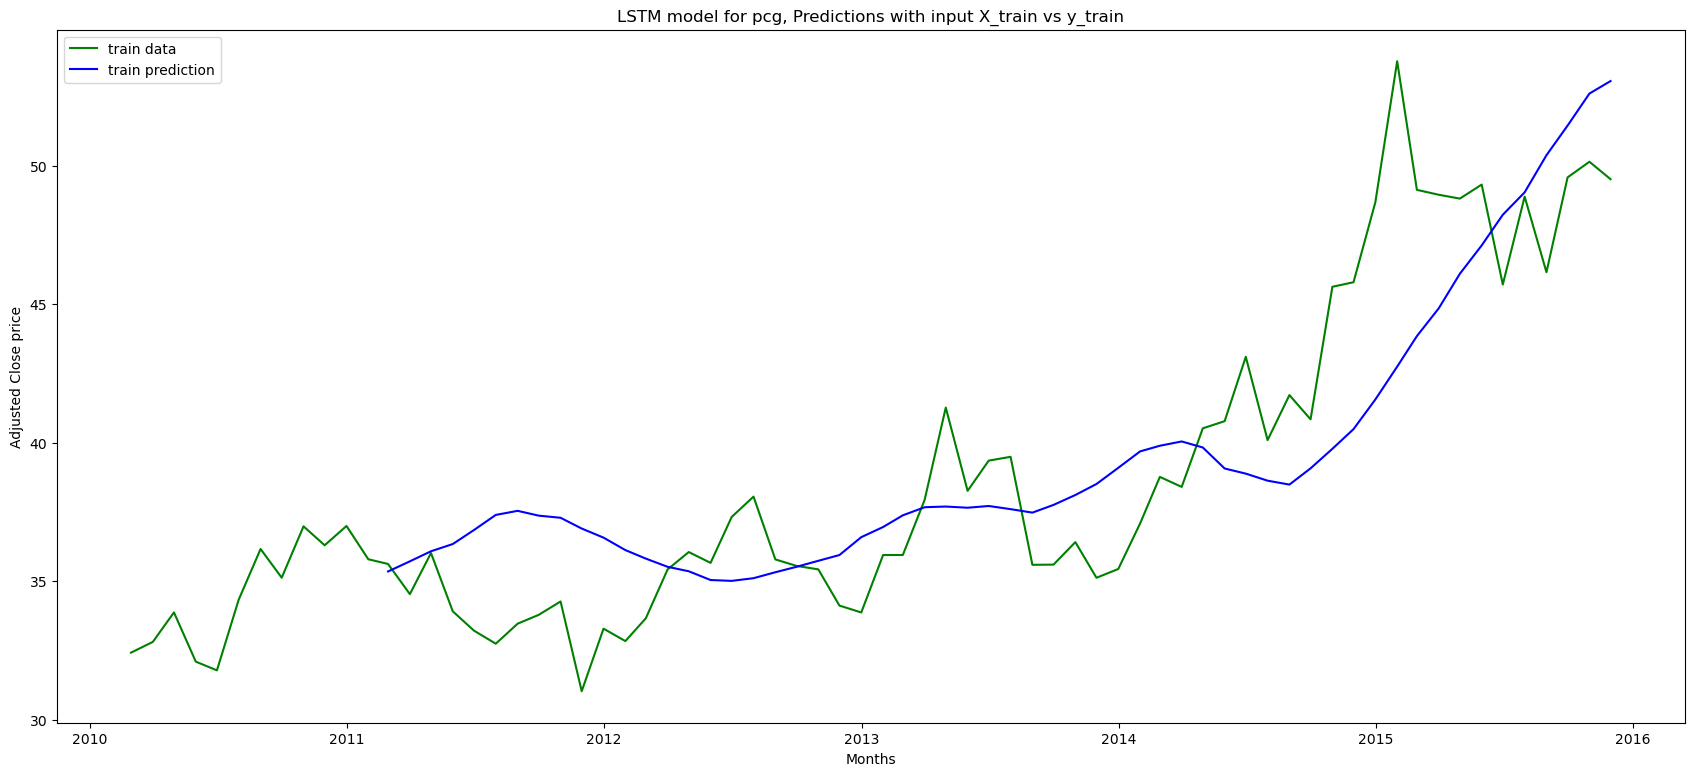

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


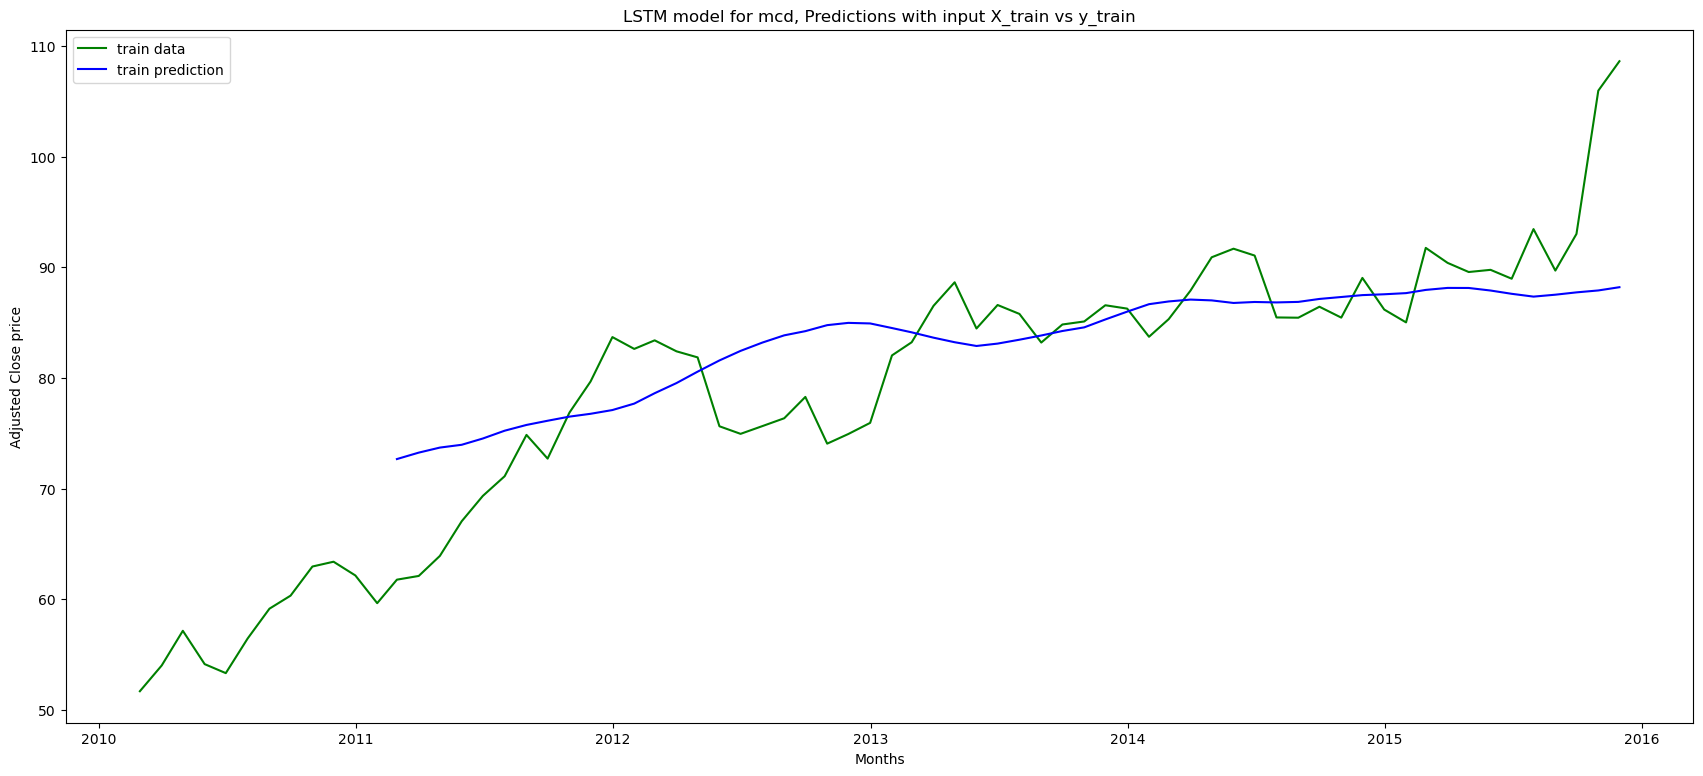

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


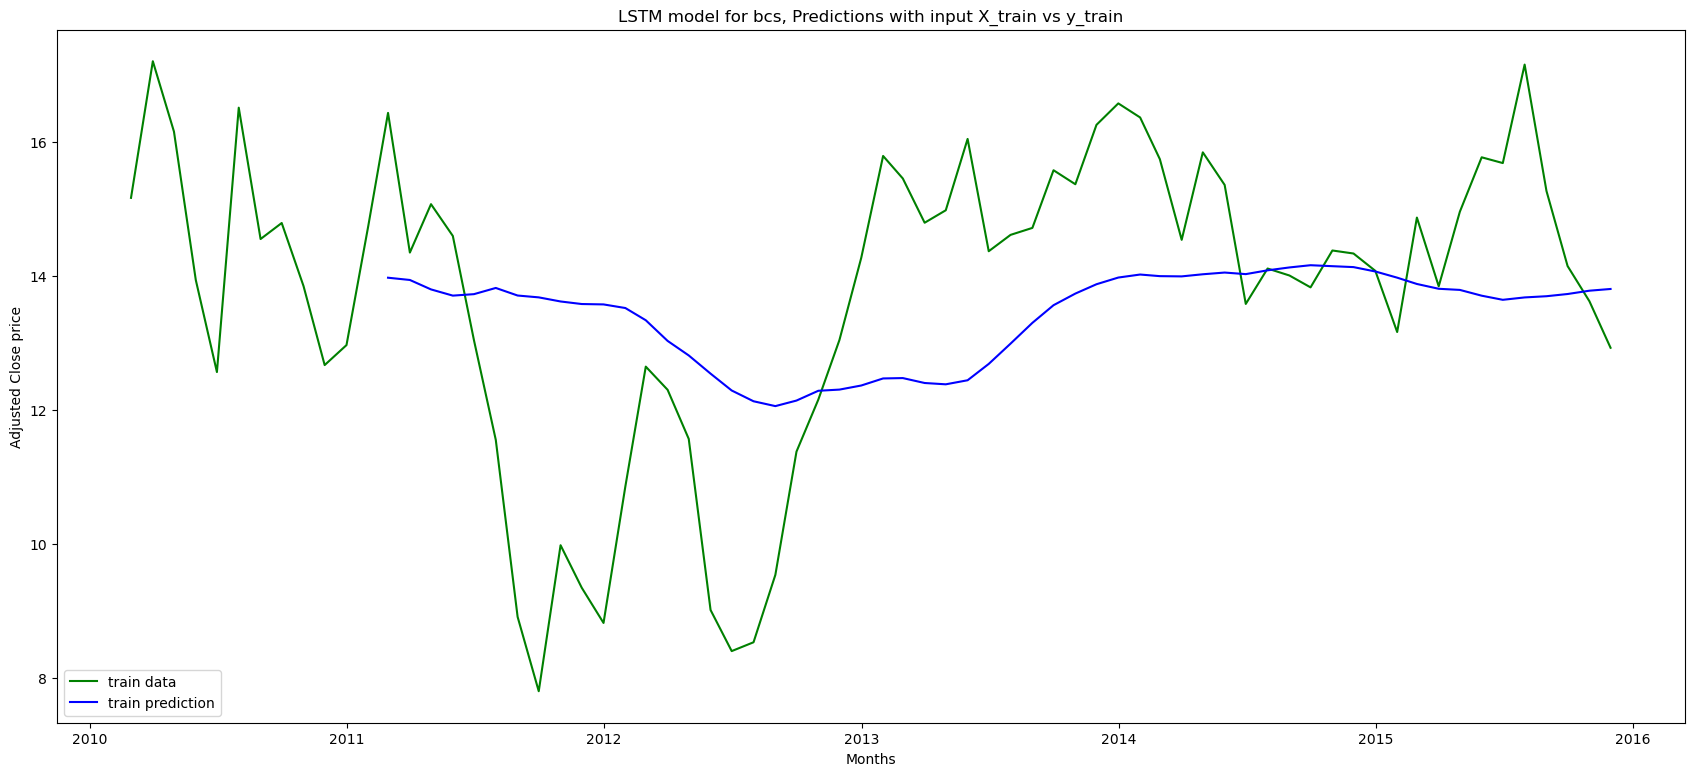

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


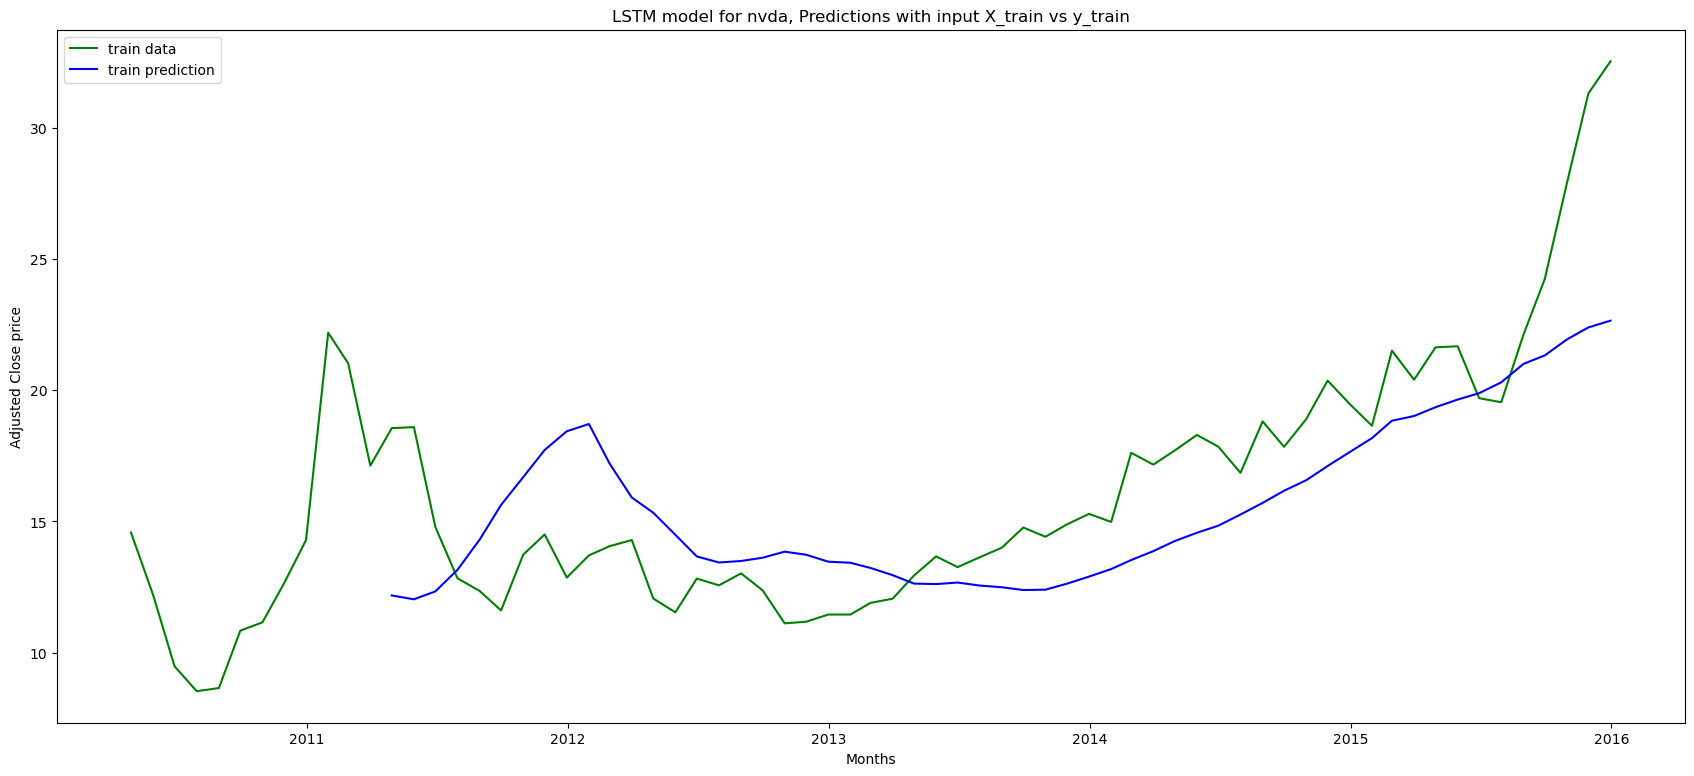

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step  


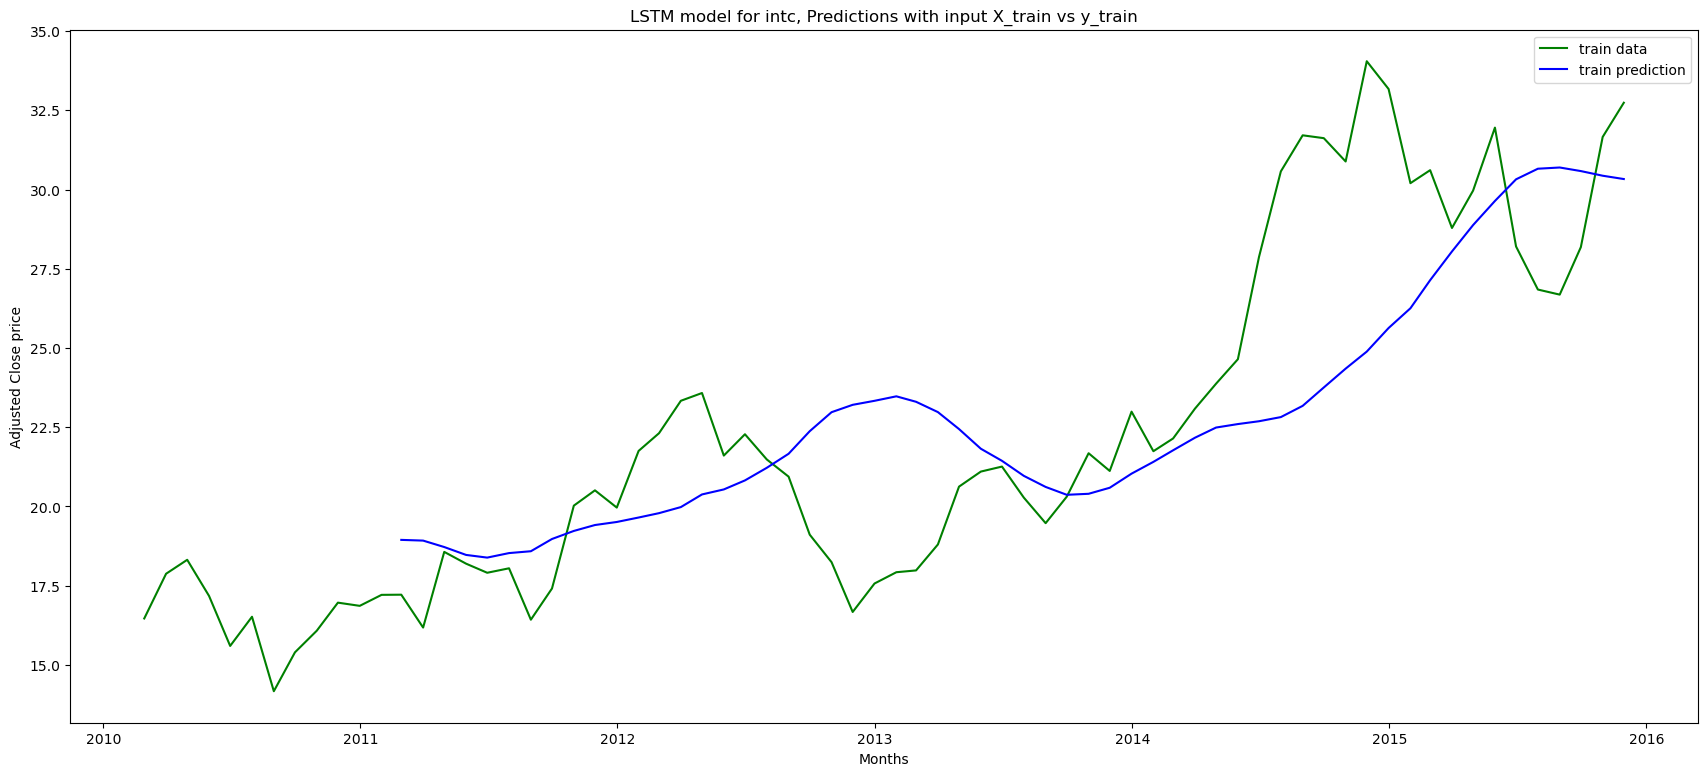

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


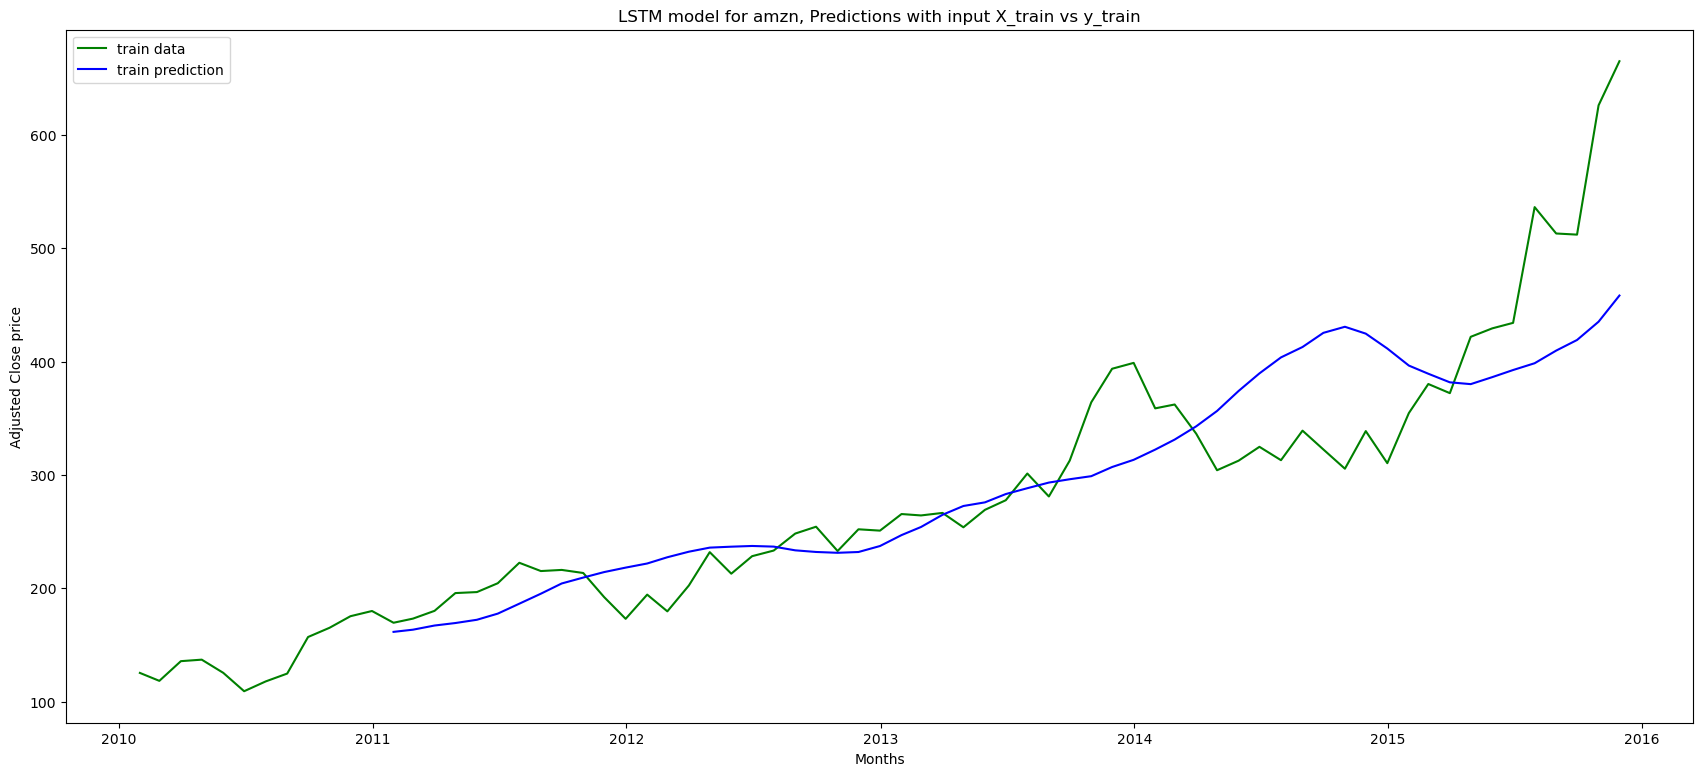

In [21]:
y_preds = {}

for t in tickers:
    y_preds[t] = models[t].predict(X_trains[t])  # predictions
    y_preds[t] = scales[t].inverse_transform(y_preds[t]) # scaling back from 0-1 to original
    
    # Visualizing predictions in train dataset
    plt.figure(figsize = (21,9))
    plt.plot(train_dfs[t]['Date'],train_dfs[t]['Close'], color = "g", label = "train data")
    plt.plot(train_dfs[t]['Date'].iloc[Lookback:],y_preds[t], color = "b", label = "train prediction" )
    plt.xlabel("Months")
    plt.ylabel("Adjusted Close price")
    plt.title(f"LSTM model for {t}, Predictions with input X_train vs y_train")
    plt.legend()
    plt.show()

Making test predictions.

In [23]:
y_test_preds = {}

for t in tickers:
    # predictions for test
    y_test_preds[t] = models[t].predict(X_tests[t])
    y_test_preds[t] = test_scales[t].inverse_transform(y_test_preds[t])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Making combined charts with train and test data and predictions.

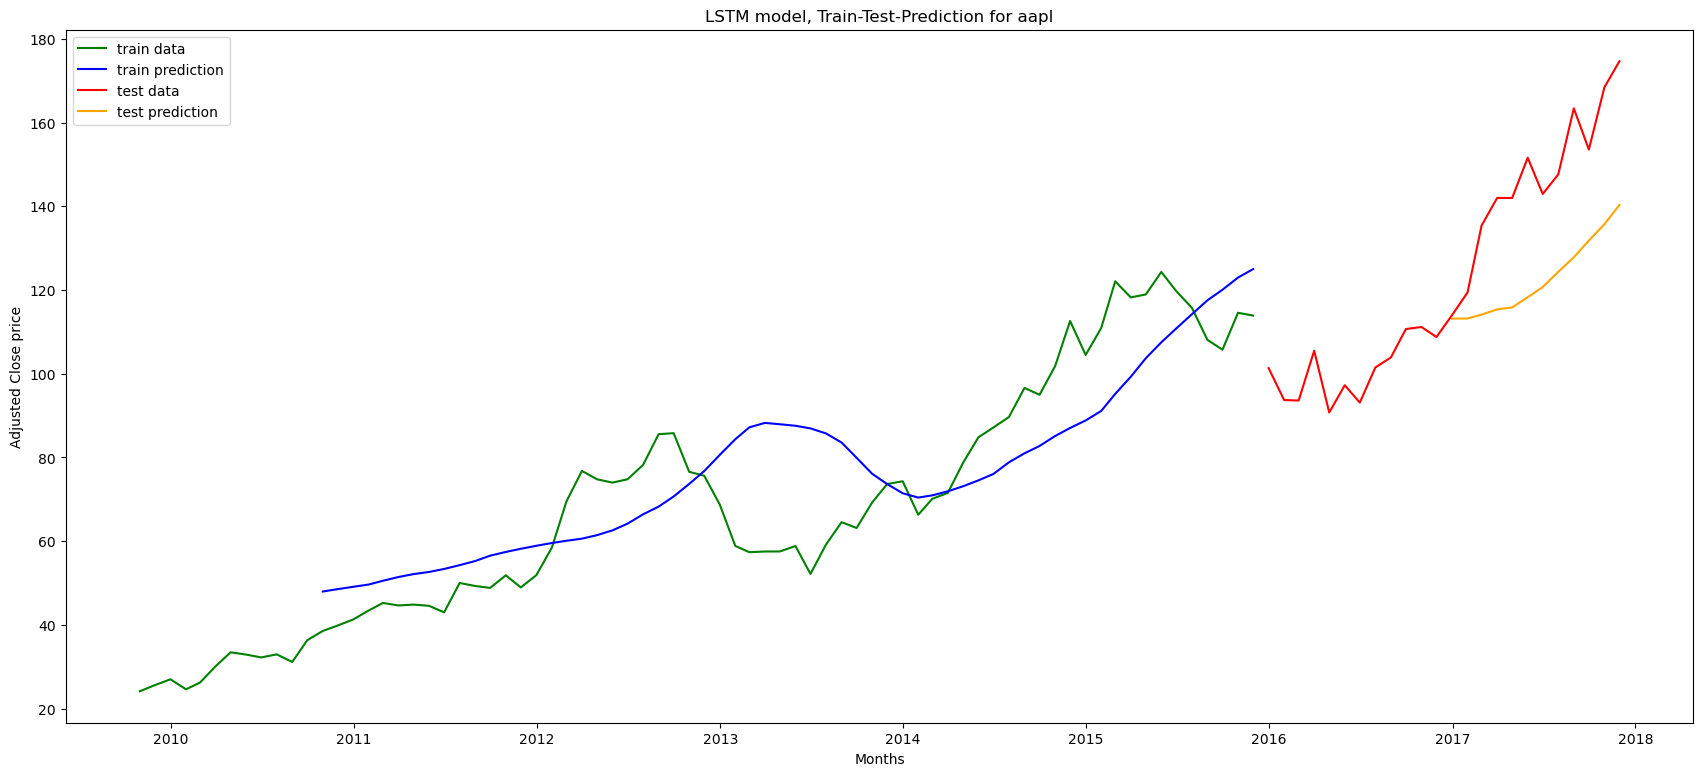

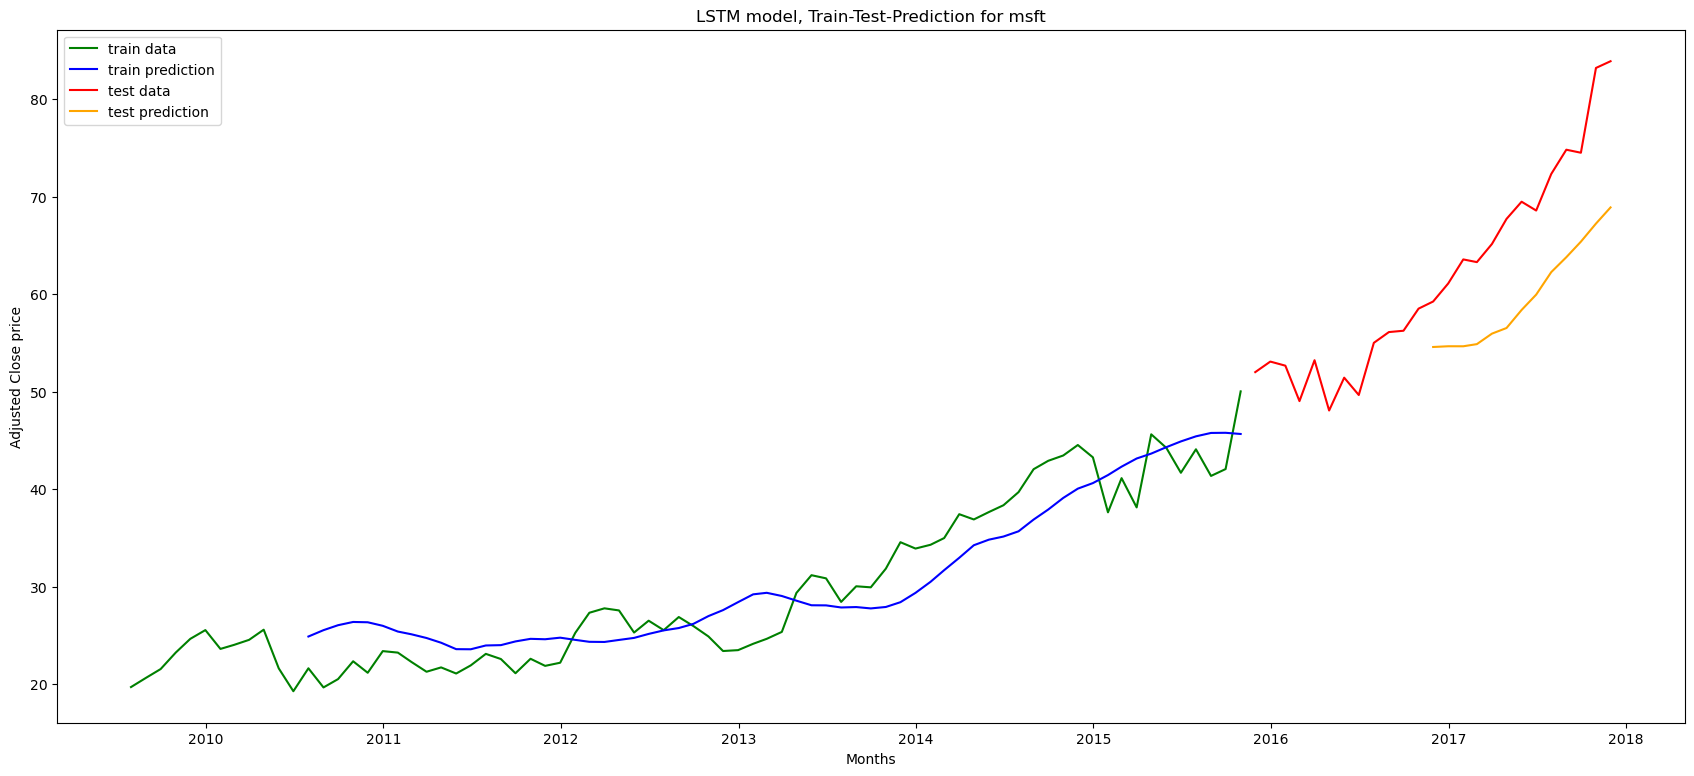

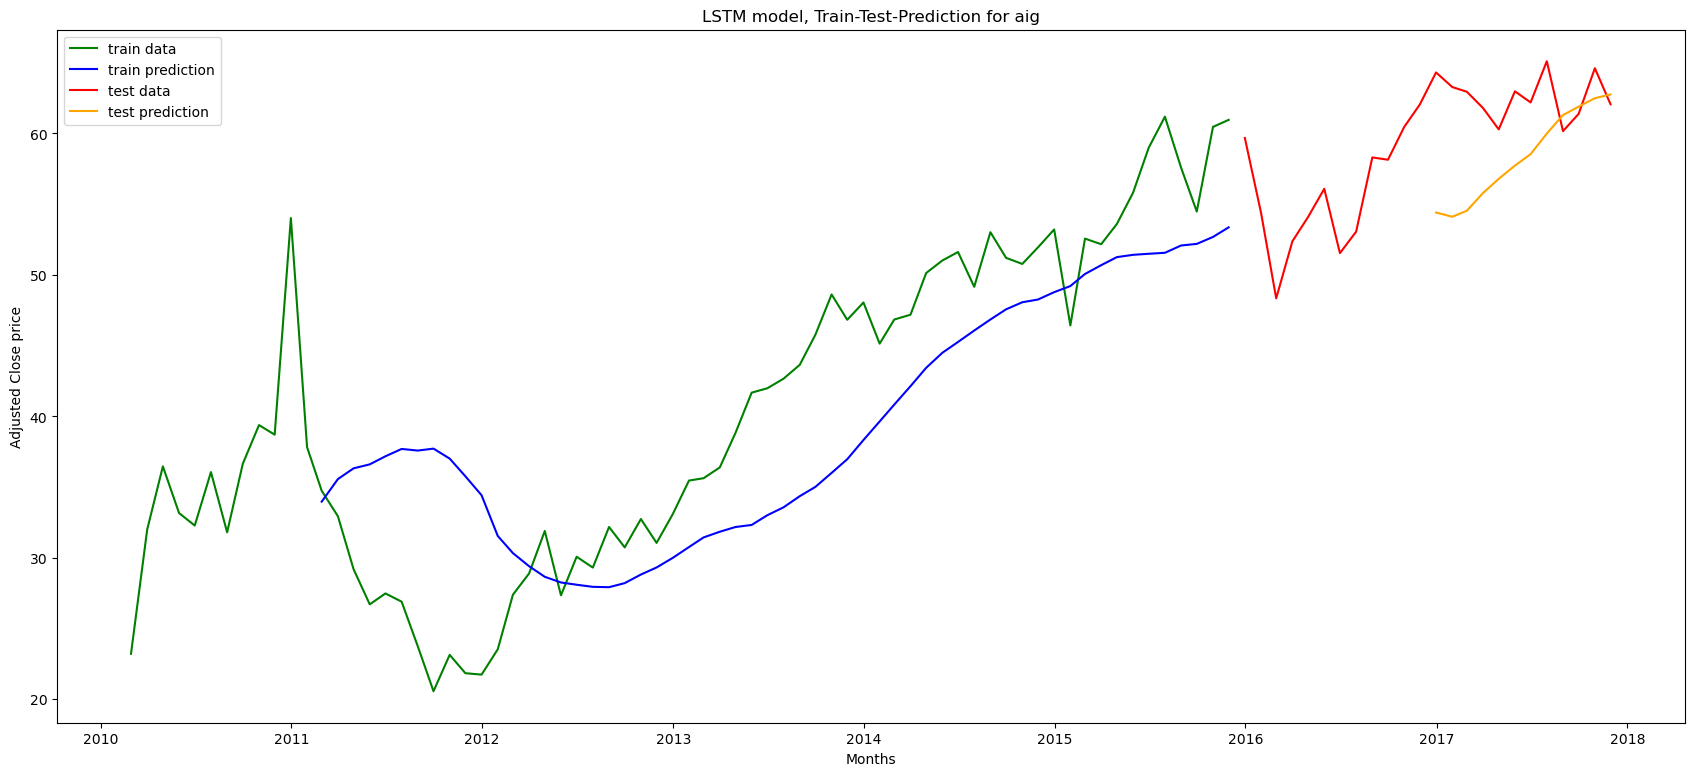

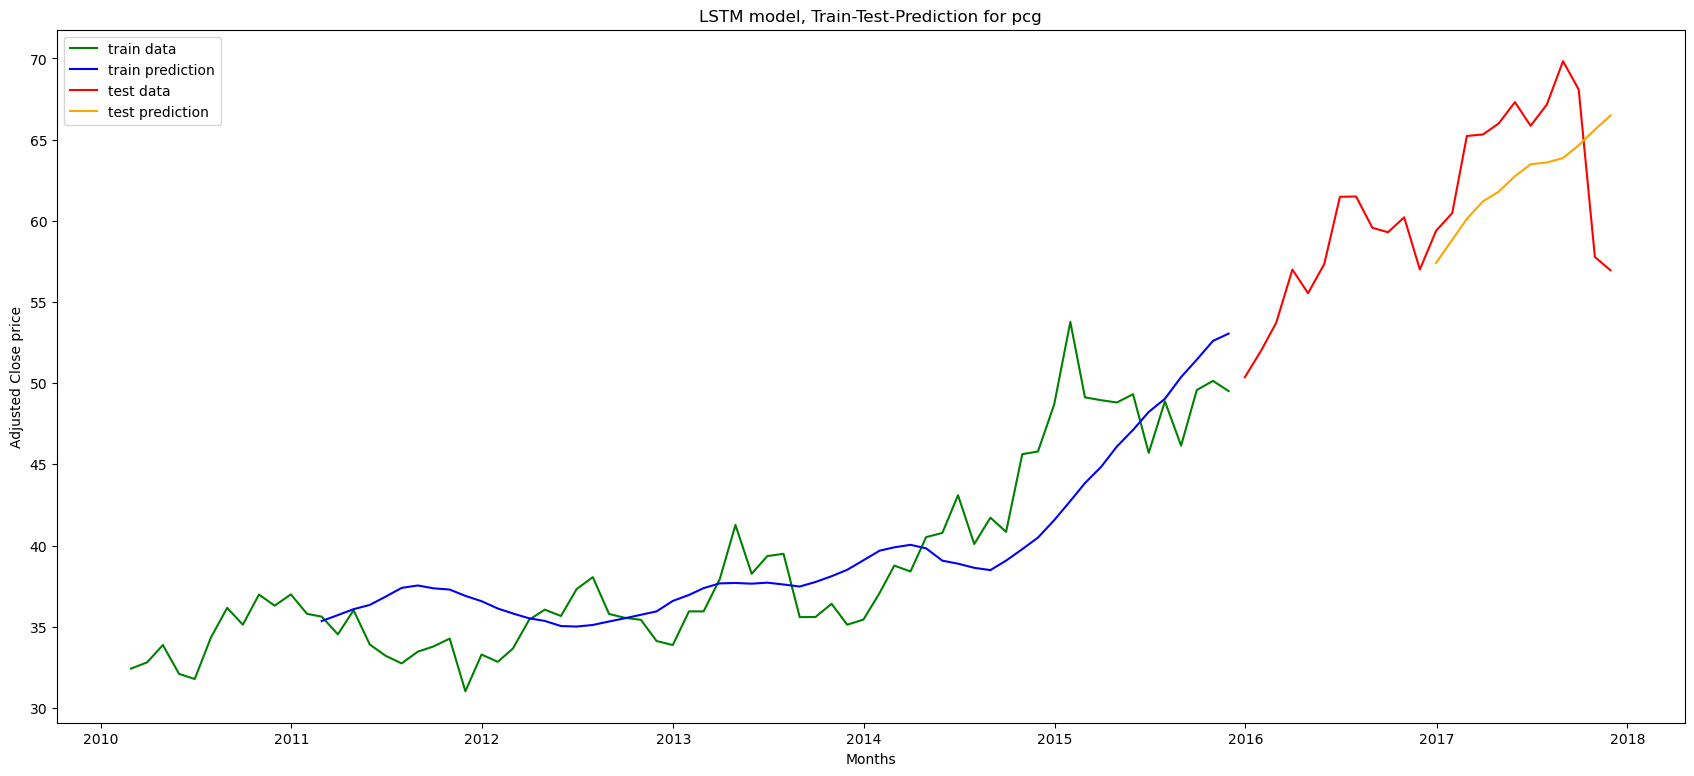

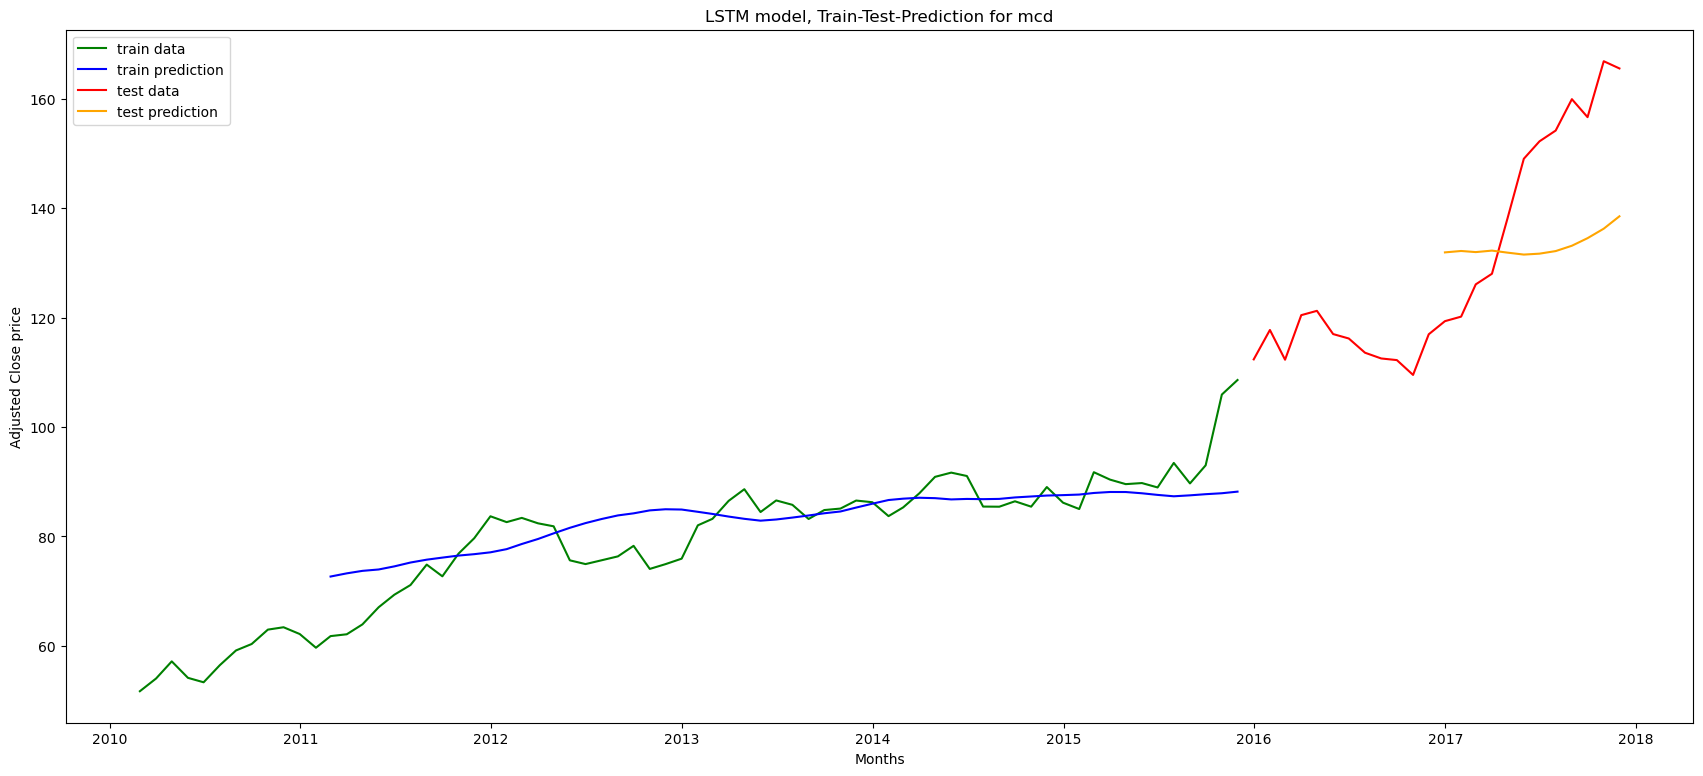

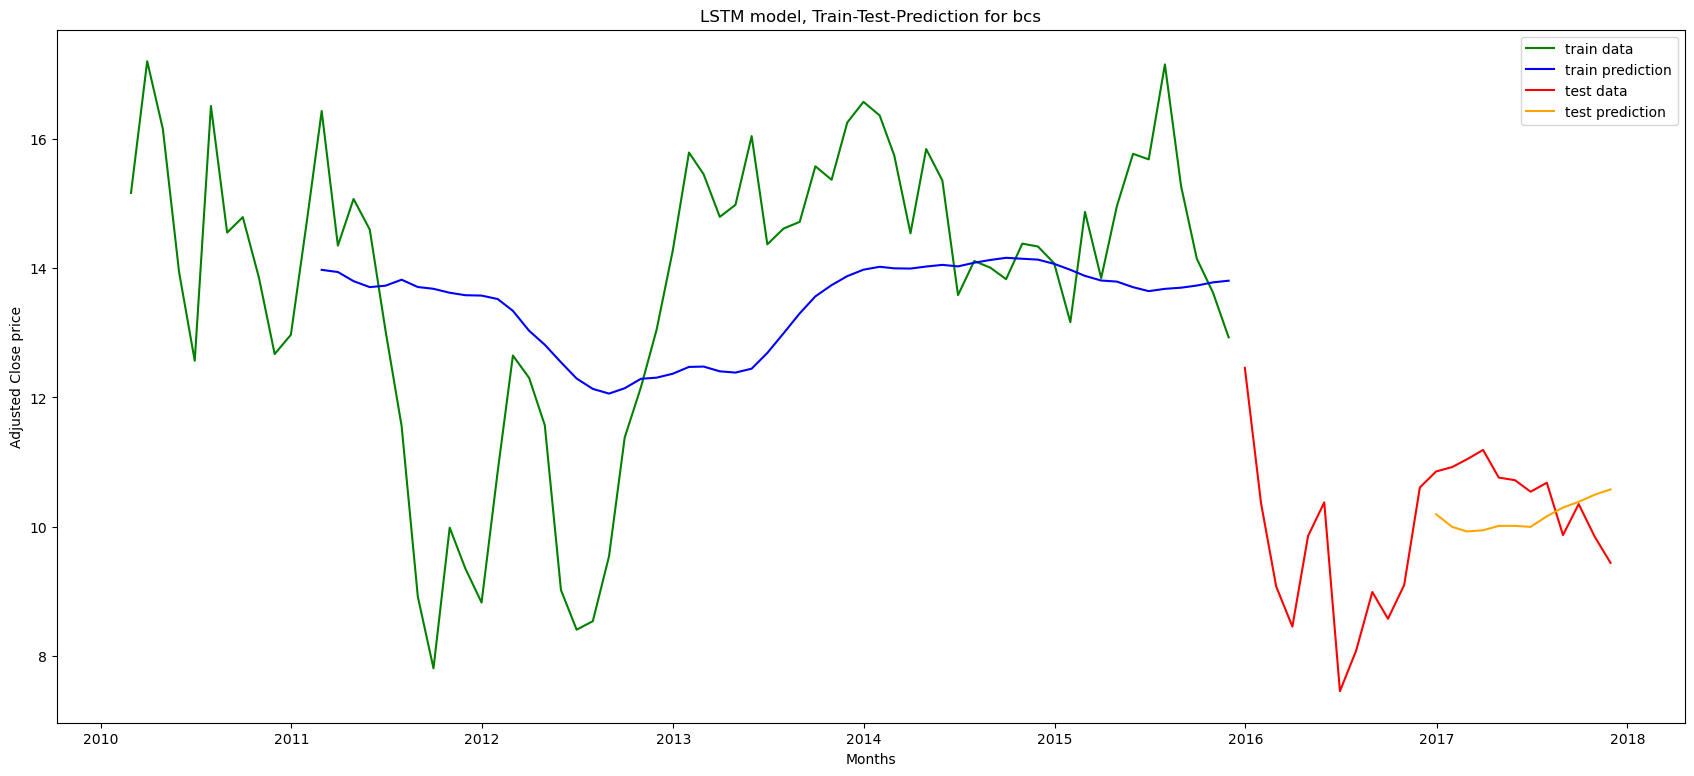

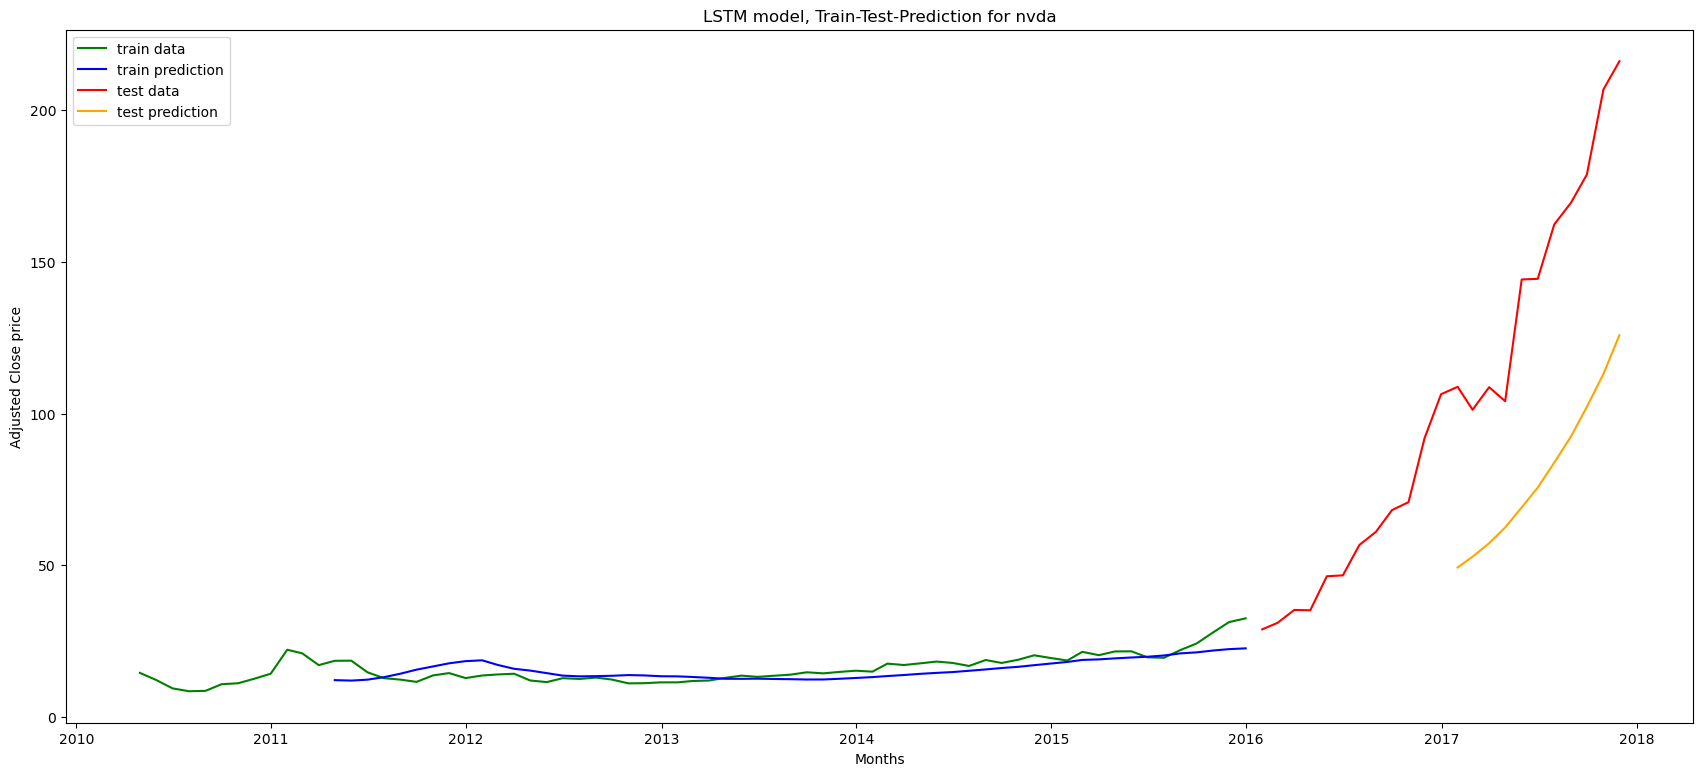

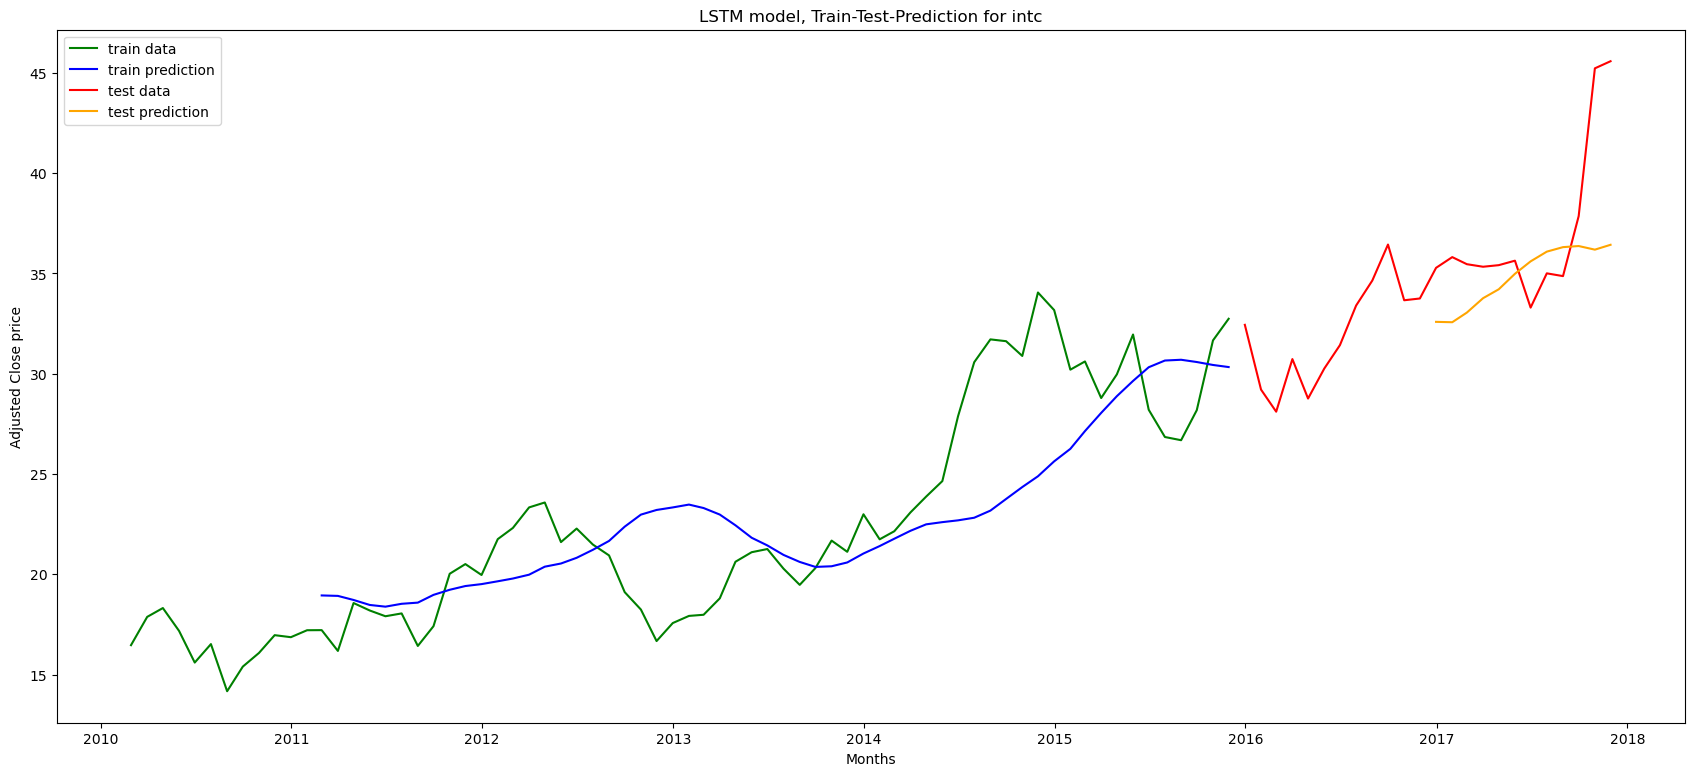

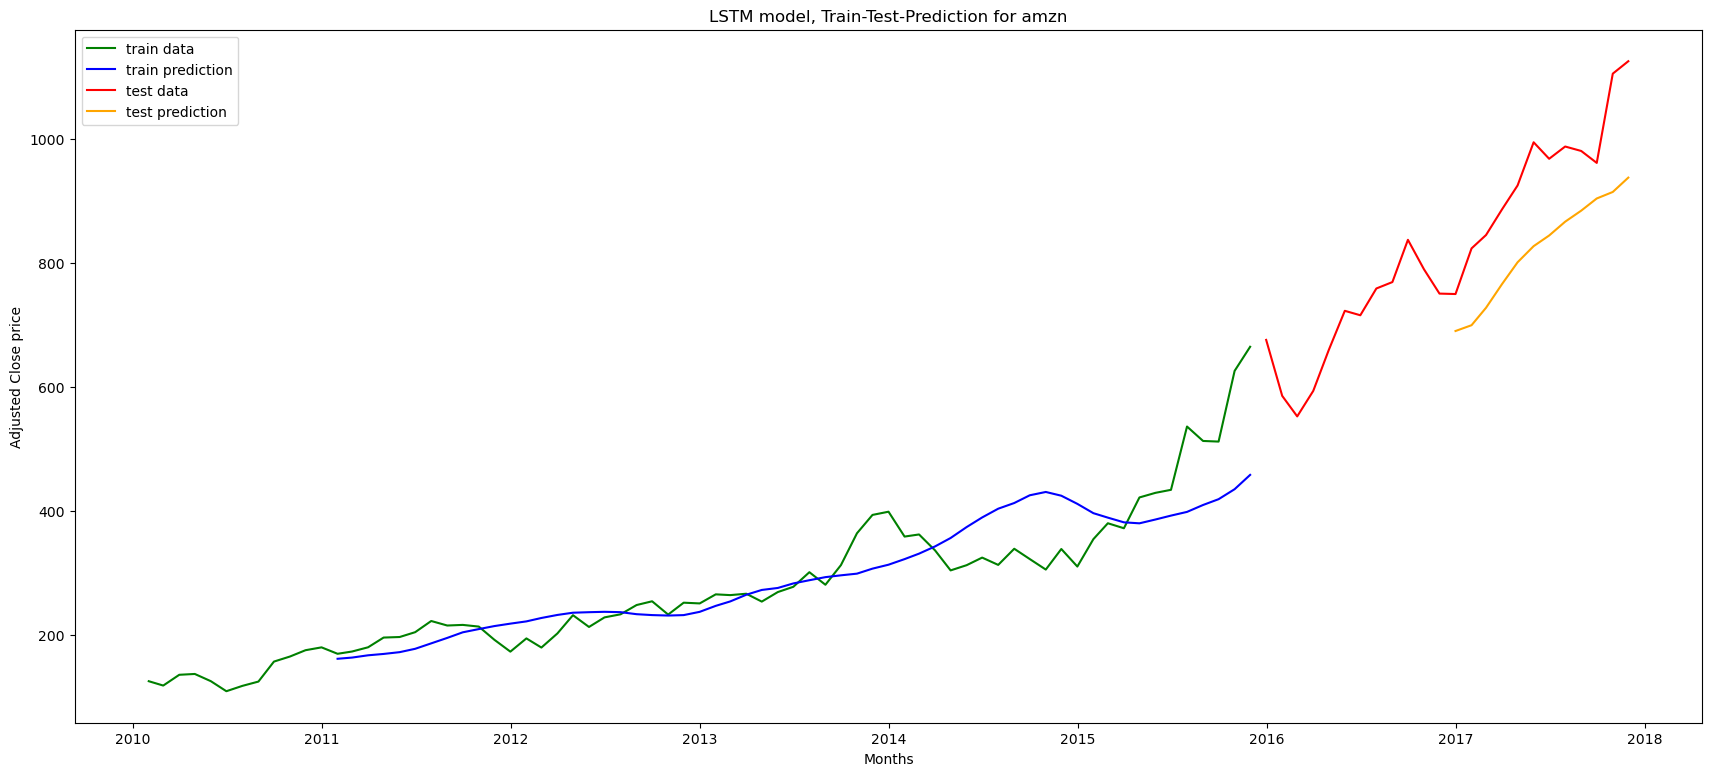

In [25]:
# Combined chart with train and test with predictions
for t in tickers:
    plt.subplots(figsize =(21,9))
    plt.plot(train_dfs[t]['Date'],train_dfs[t]['Close'], color = "g", label = "train data")
    plt.plot(train_dfs[t]['Date'].iloc[Lookback:],y_preds[t], color = "b", label = "train prediction" )
    plt.plot(test_dfs[t]['Date'], test_dfs[t]['Close'], label = "test data", color = "r")
    plt.plot(test_dfs[t]['Date'].iloc[Lookback:], y_test_preds[t], label = "test prediction", color = "orange")
    plt.xlabel("Months")
    plt.ylabel("Adjusted Close price")
    plt.title(f"LSTM model, Train-Test-Prediction for {t}")
    plt.legend()
    plt.show()

Calculating MSE for train and for test.

In [27]:
mse_train, mse_test = {},{}

for t in tickers:
    # Calculating MSE for train 
    y_trains_unscaled = scales[t].inverse_transform(y_trains[t])
    mse_train[t] = mean_squared_error(y_trains_unscaled, y_preds[t])
    print(f'Mean squared error for {t} train {mse_train[t]:.6}')

    # Calculating MSE for test
    y_test_unscaled = test_scales[t].inverse_transform(y_tests[t])
    mse_test[t] = mean_squared_error(y_test_unscaled, y_test_preds[t])
    print(f'Mean squared error for {t} test {mse_test[t]:.6}')

Mean squared error for aapl train 222.64
Mean squared error for aapl test 668.508
Mean squared error for msft train 11.4565
Mean squared error for msft test 108.055
Mean squared error for aig train 53.6861
Mean squared error for aig test 31.2125
Mean squared error for pcg train 10.5405
Mean squared error for pcg test 25.529
Mean squared error for mcd train 35.9052
Mean squared error for mcd test 373.956
Mean squared error for bcs train 5.16604
Mean squared error for bcs test 0.634905
Mean squared error for nvda train 10.7456
Mean squared error for nvda test 5049.07
Mean squared error for intc train 12.9105
Mean squared error for intc test 17.0187
Mean squared error for amzn train 3869.06
Mean squared error for amzn test 17068.9


Calculating MSE with actual vs. SMA. SMA serves as a baseline prediction. Should be compared with MSE for test.

In [29]:
sma_window = 8
sma = {}
mse_sma = {}

for t in tickers:
    # Calculating SMA
    sma[t] = stock_dfs[t]['Close'].rolling(sma_window).mean()
    # Calculating MSE for SMA as a baseline
    mse_sma[t] = mean_squared_error(stock_dfs[t]['Close'].iloc[sma_window - 1:], sma[t].dropna())
    print(f'Mean squared error for {t} sma baseline {mse_sma[t]:.6}')

Mean squared error for aapl sma baseline 110.728
Mean squared error for msft sma baseline 12.6554
Mean squared error for aig sma baseline 18.6416
Mean squared error for pcg sma baseline 9.05872
Mean squared error for mcd sma baseline 57.1508
Mean squared error for bcs sma baseline 2.89634
Mean squared error for nvda sma baseline 226.485
Mean squared error for intc sma baseline 6.17442
Mean squared error for amzn sma baseline 3428.65


Charting everything and SMA in addition

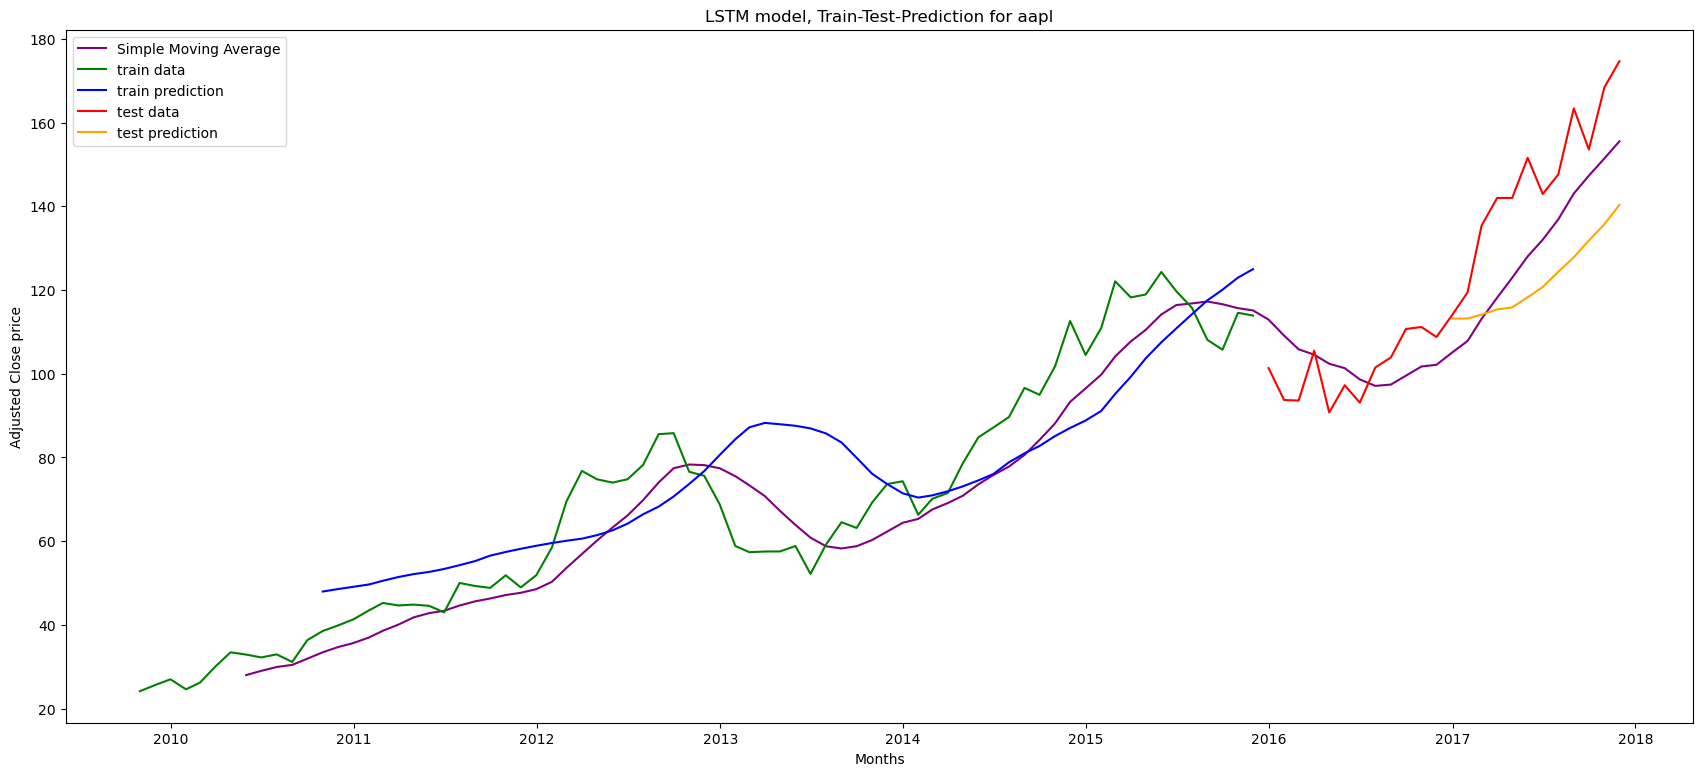

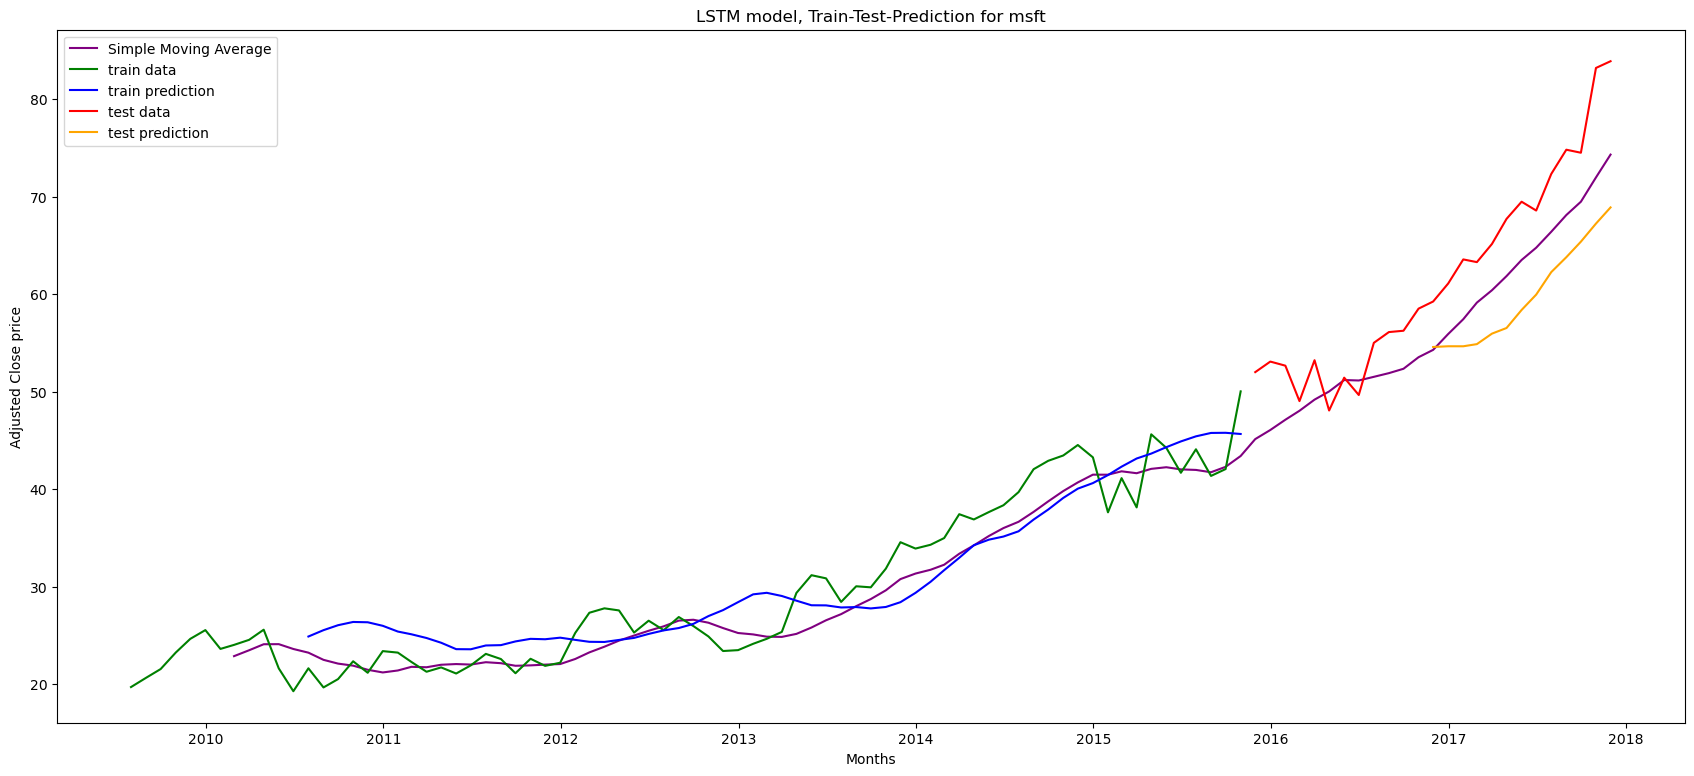

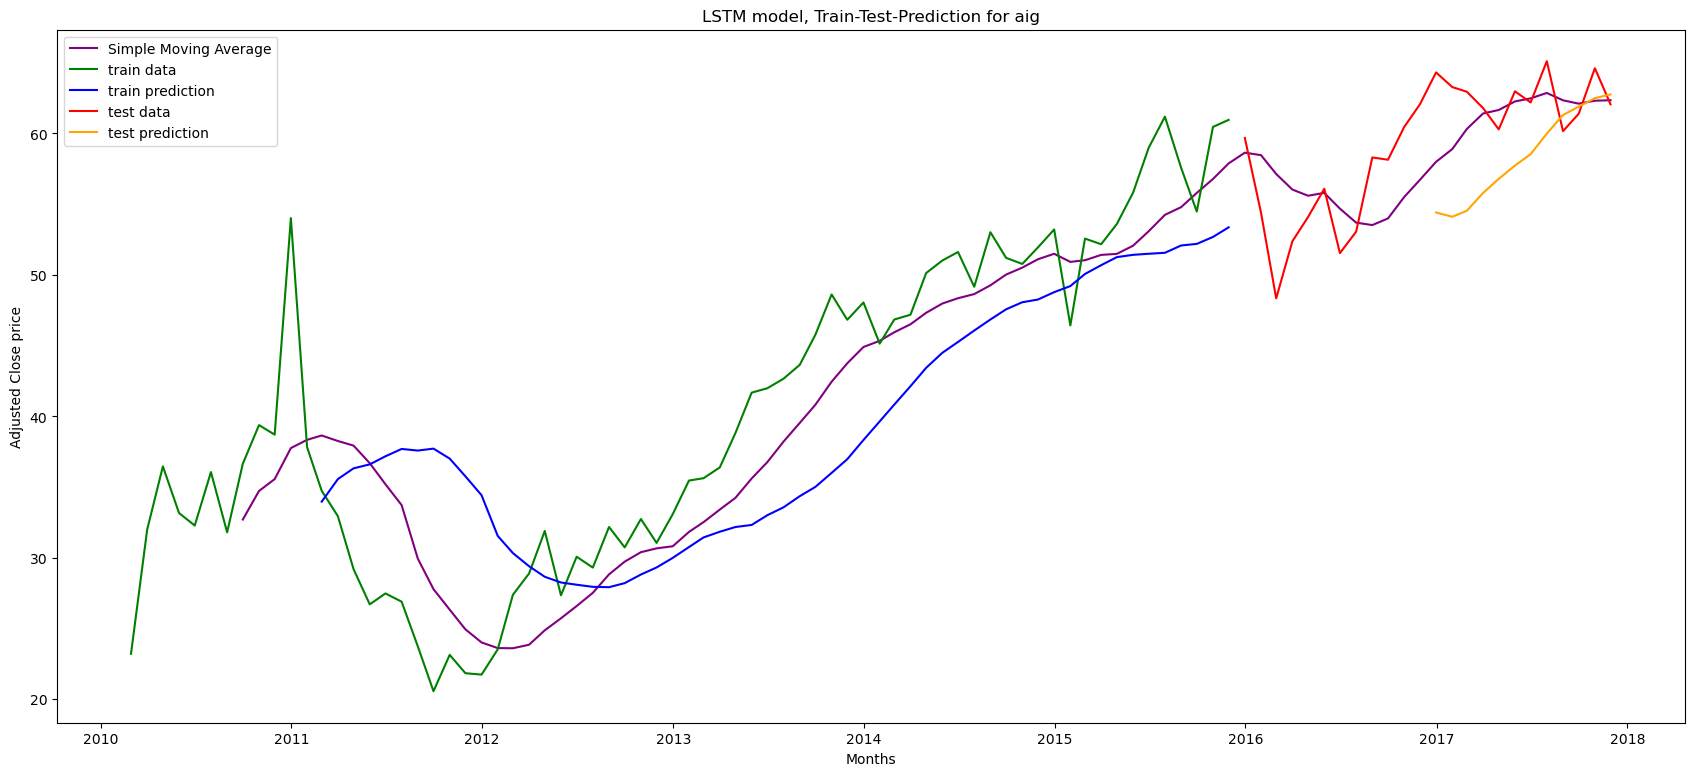

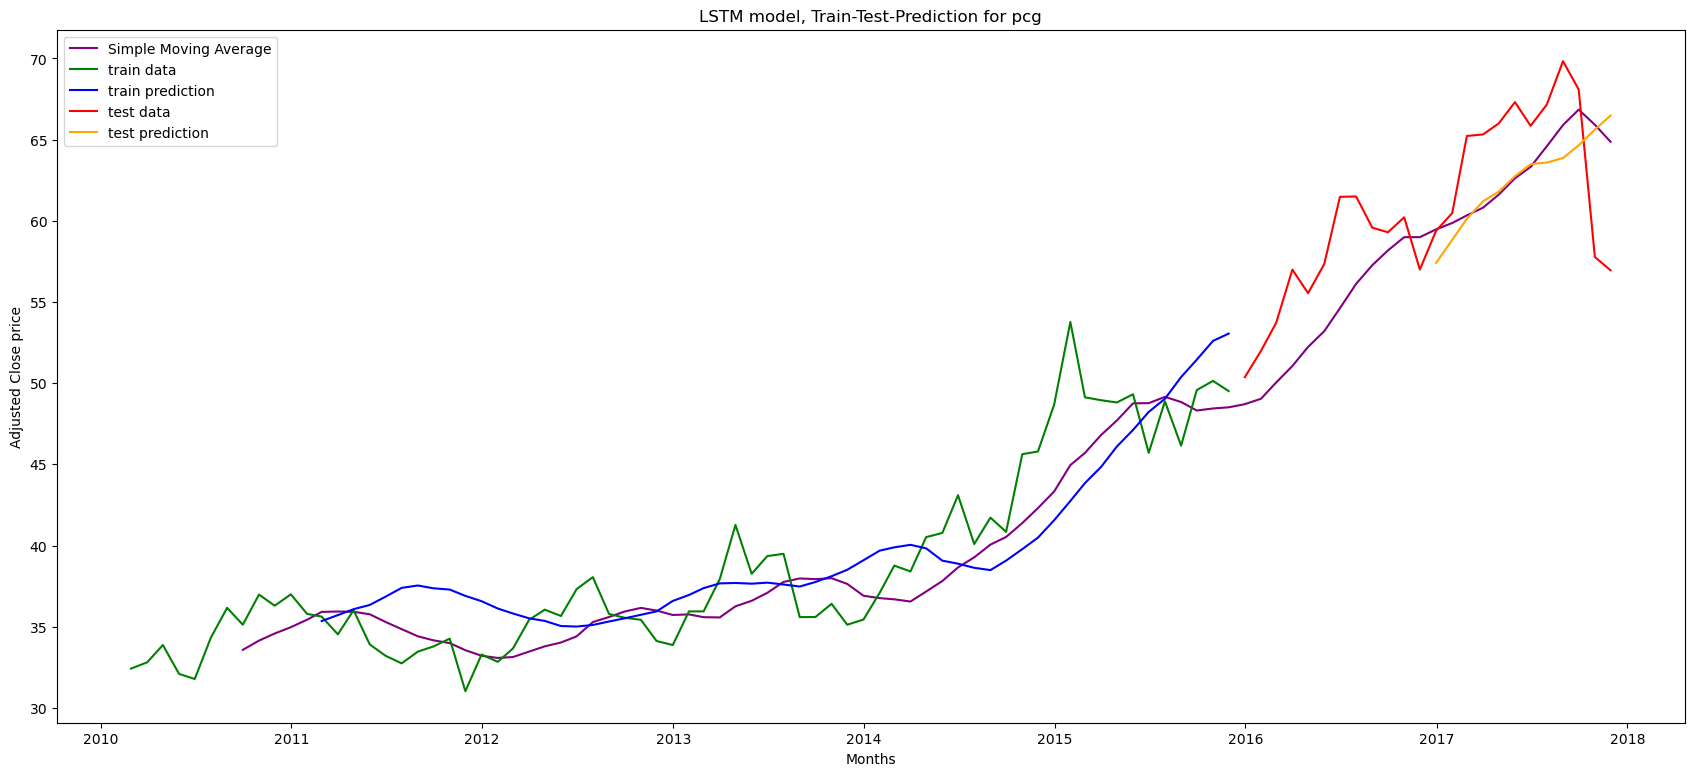

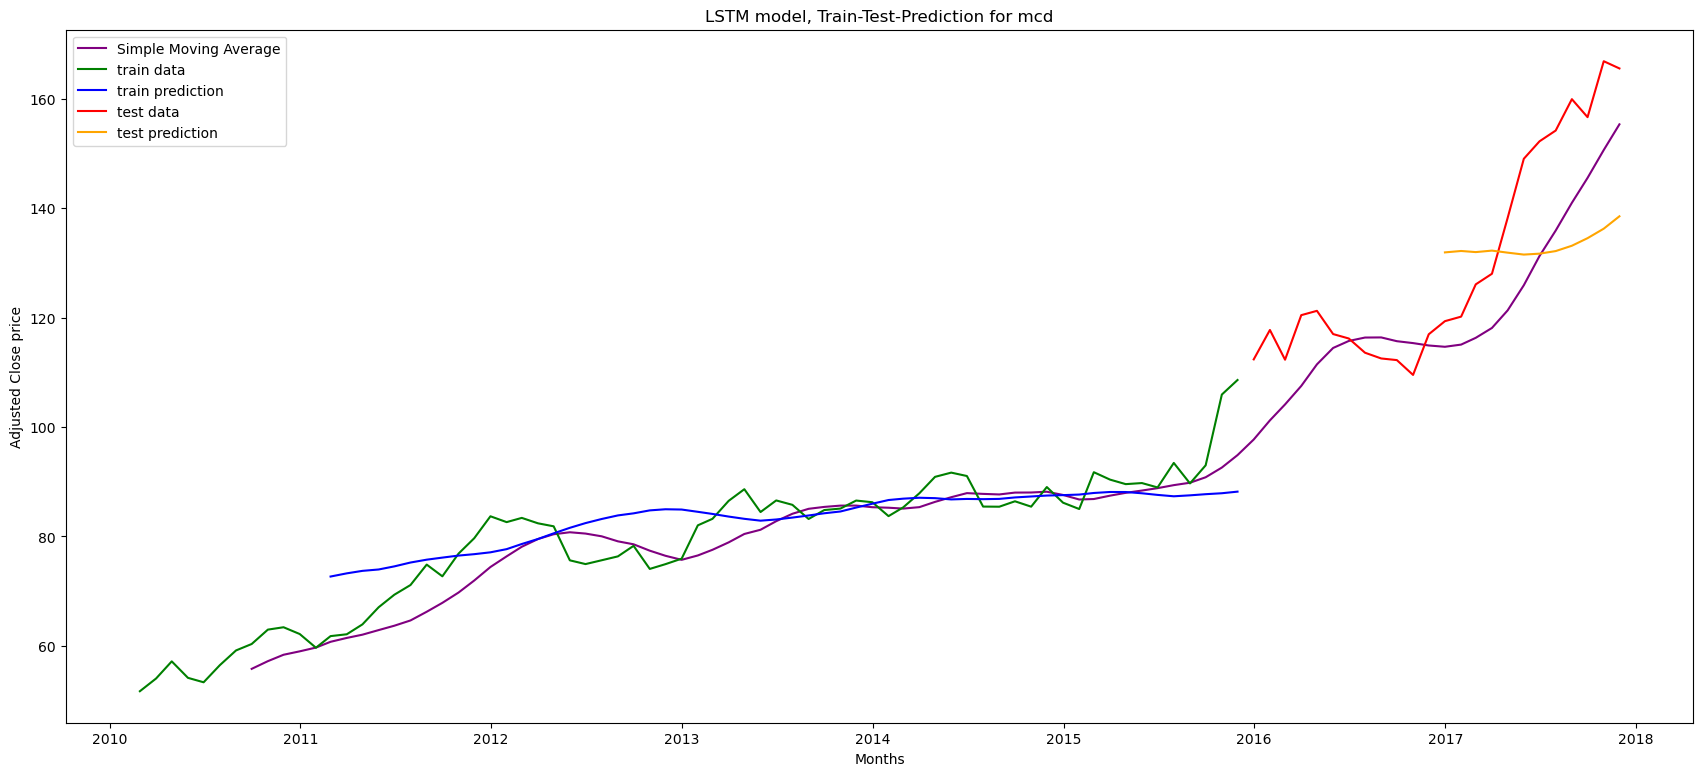

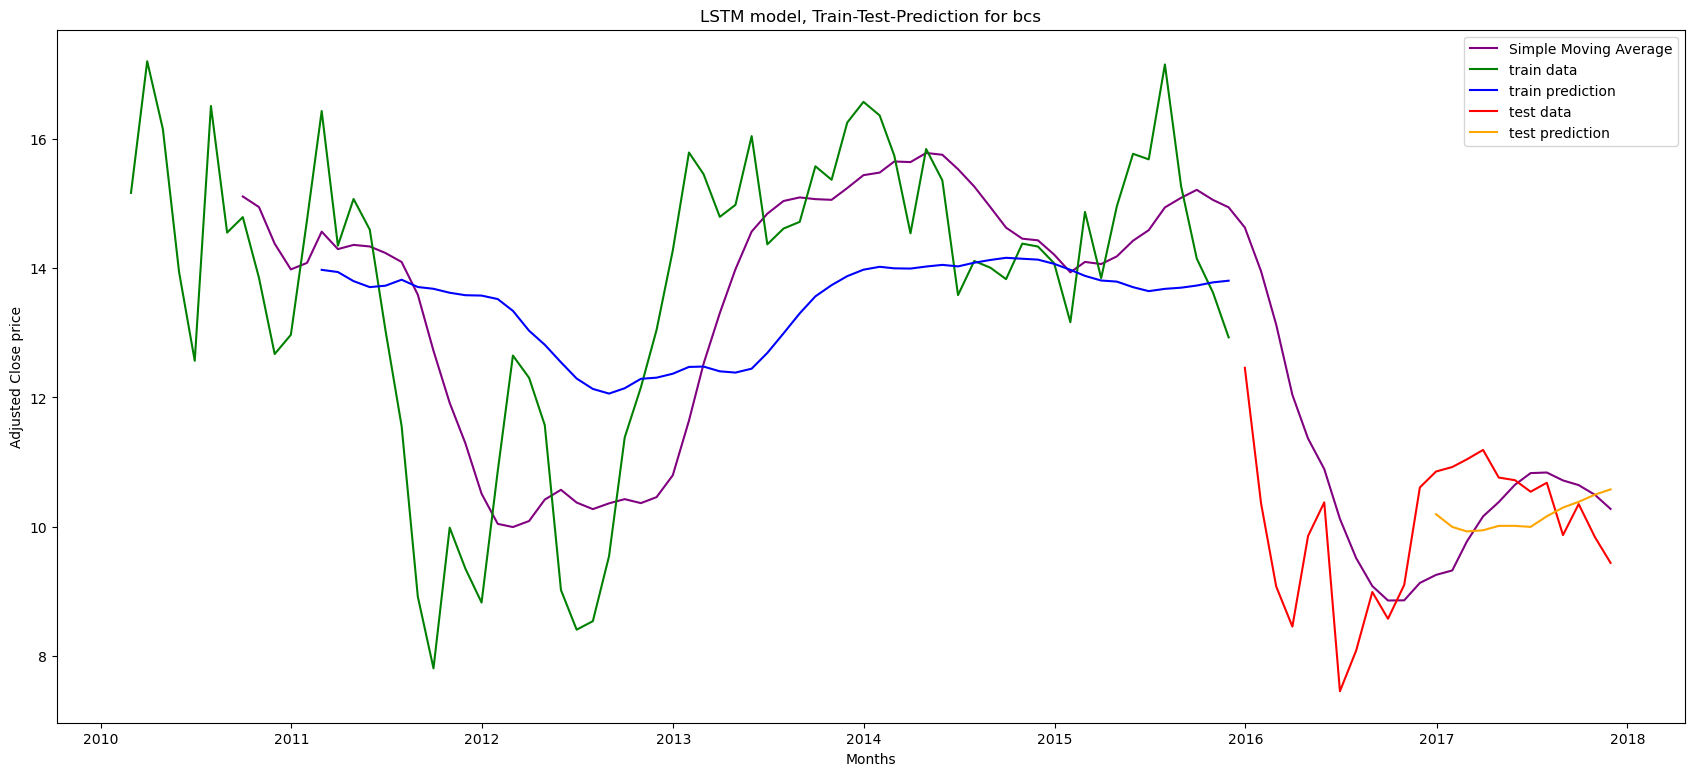

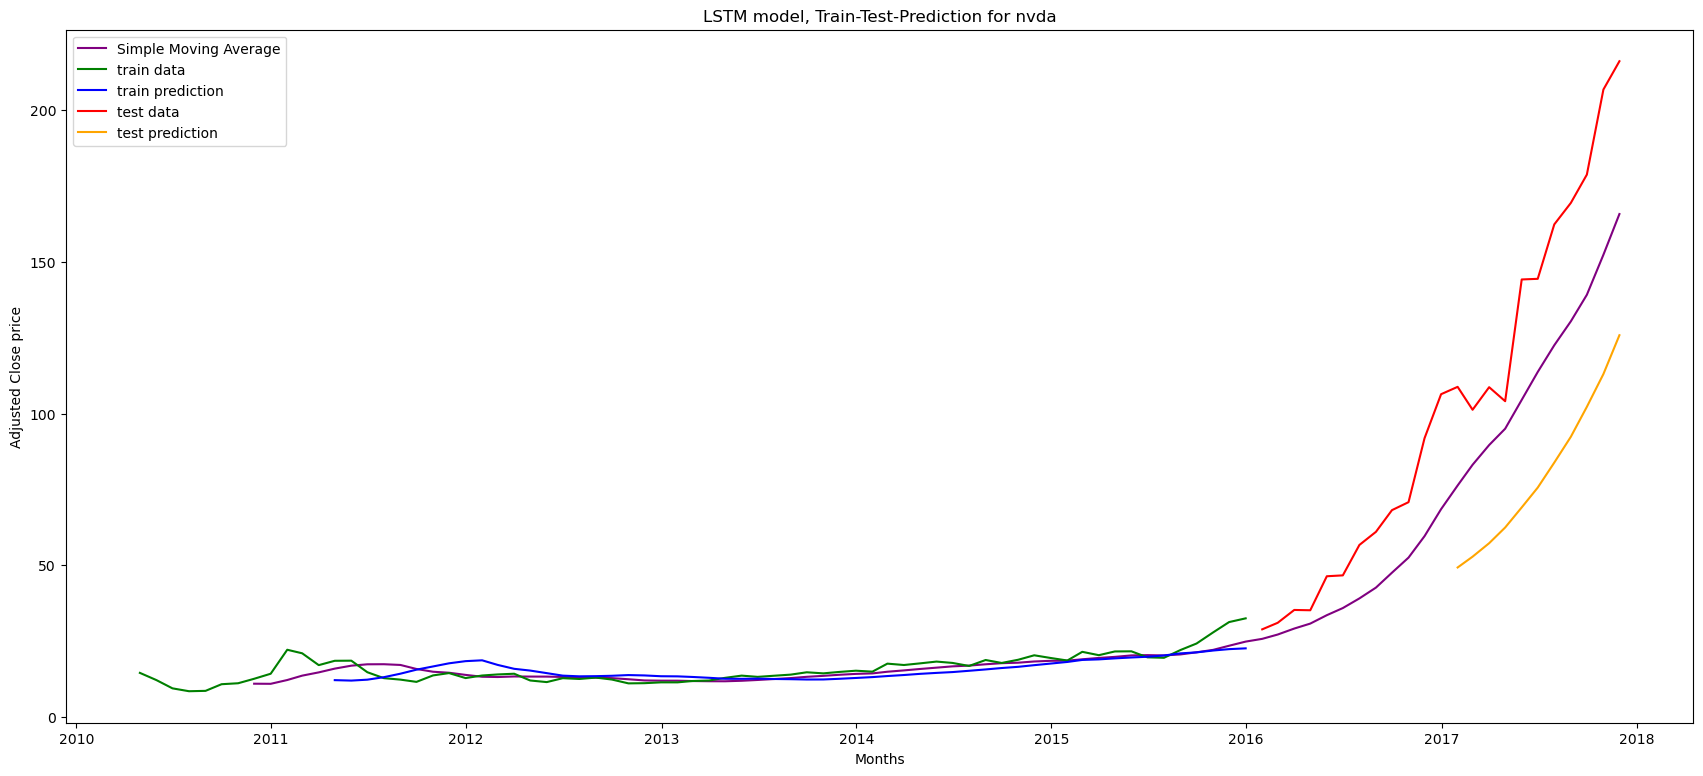

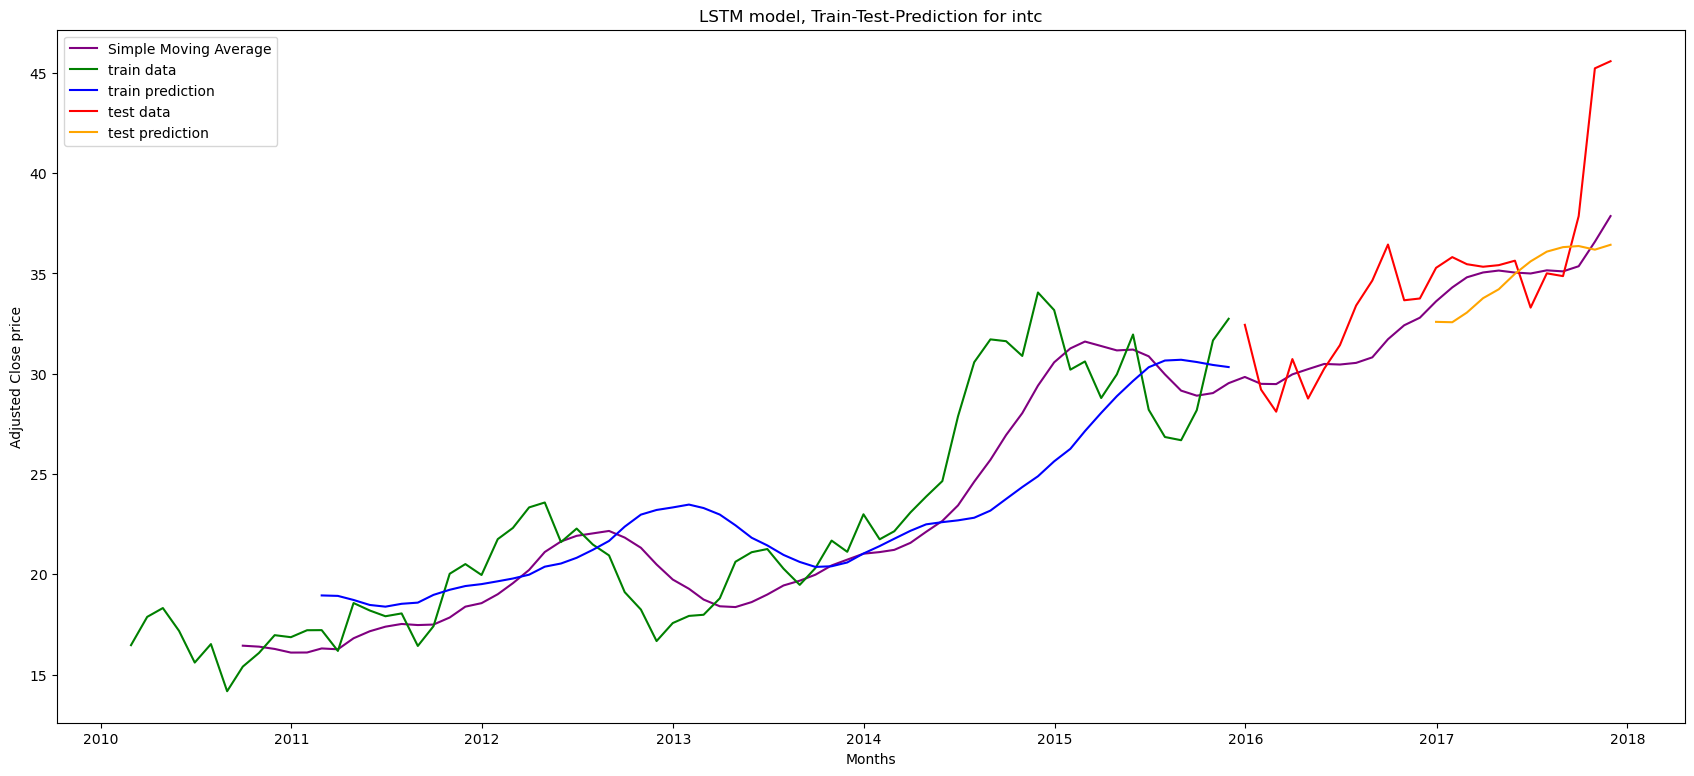

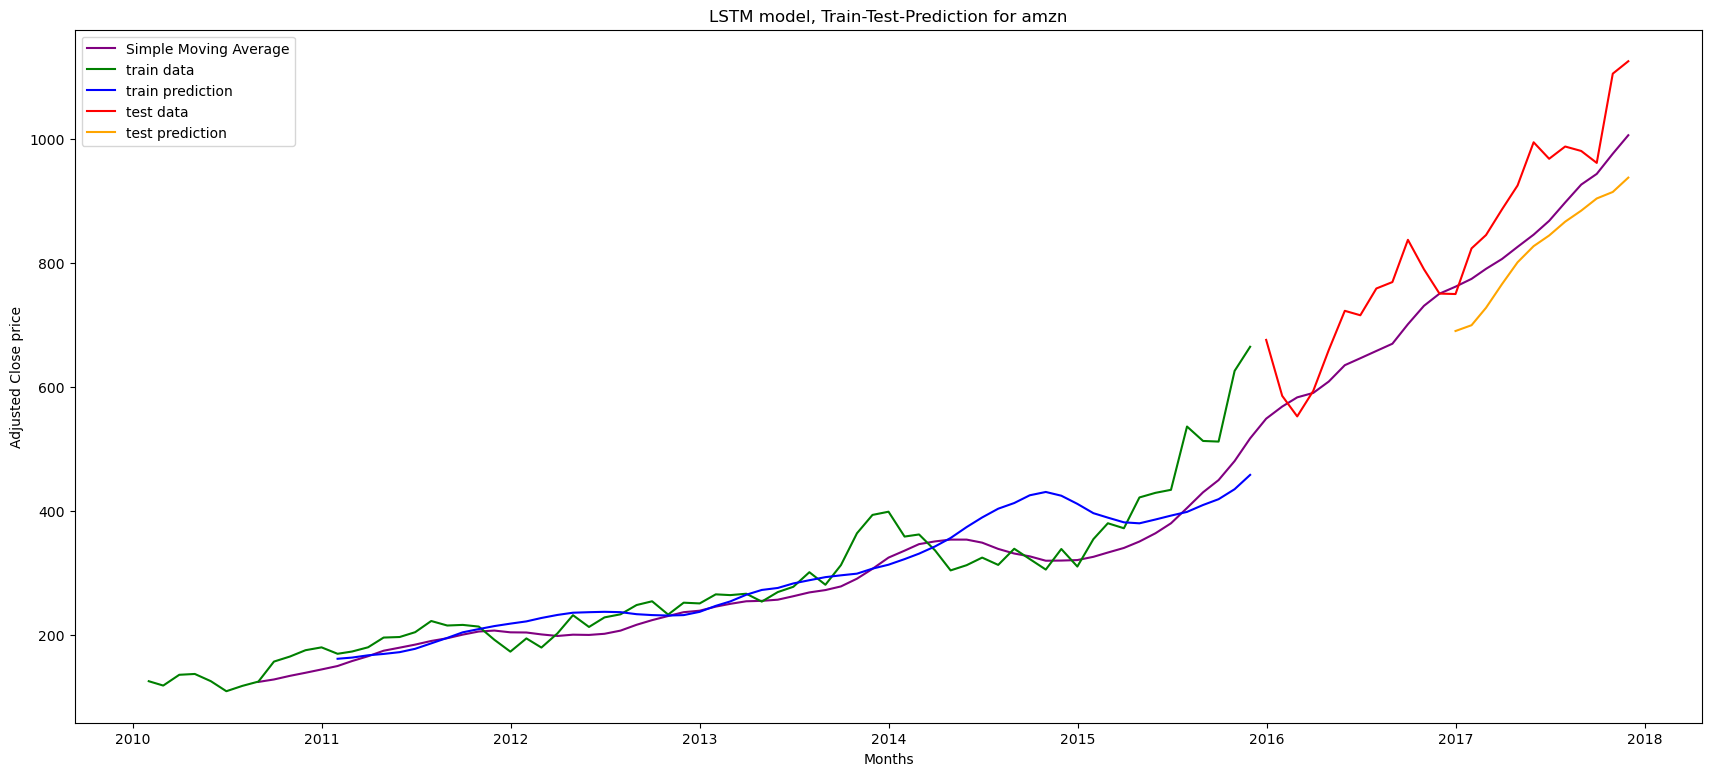

In [31]:
for t in tickers:
    plt.subplots(figsize =(21,9))
    # Adding SMA to plot
    plt.plot(stock_dfs[t]['Date'], sma[t], label = "Simple Moving Average", color = "purple")
    plt.plot(train_dfs[t]['Date'],train_dfs[t]['Close'], color = "g", label = "train data")
    plt.plot(train_dfs[t]['Date'].iloc[Lookback:],y_preds[t], color = "b", label = "train prediction" )
    plt.plot(test_dfs[t]['Date'], test_dfs[t]['Close'], label = "test data", color = "r")
    plt.plot(test_dfs[t]['Date'].iloc[Lookback:], y_test_preds[t], label = "test prediction", color = "orange")
    plt.xlabel("Months")
    plt.ylabel("Adjusted Close price")
    plt.title(f"LSTM model, Train-Test-Prediction for {t}")
    plt.legend()
    plt.show()

Saving mean squared error results into csv for future comparison with mean squared error results of other models. 

In [33]:
mse_df_ppfs = pd.DataFrame([mse_test]).T.reset_index()
mse_df_ppfs.columns = ['Ticker', 'MSE_model3']
print(mse_df_ppfs.head())

mse_df = pd.read_csv('../data/results/MSE_test_2models.csv')
mse_df = mse_df.drop(columns='Unnamed: 0', axis=1)
print(mse_df.head())

mse_merged = pd.merge(mse_df, mse_df_ppfs, on='Ticker', how='left')
print(mse_merged)

mse_merged.to_csv('../data/results/MSE_test_3models.csv')

  Ticker  MSE_model3
0   aapl  668.508427
1   msft  108.055200
2    aig   31.212529
3    pcg   25.528997
4    mcd  373.955773
  Ticker  MSE_model1  MSE_model2
0   aapl  205.504838  313.463701
1   msft   23.364533  197.474476
2    aig    4.434174  108.788565
3    pcg   15.572424   50.287163
4    mcd  297.314940  804.436726
  Ticker    MSE_model1    MSE_model2    MSE_model3
0   aapl    205.504838    313.463701    668.508427
1   msft     23.364533    197.474476    108.055200
2    aig      4.434174    108.788565     31.212529
3    pcg     15.572424     50.287163     25.528997
4    mcd    297.314940    804.436726    373.955773
5    bcs      2.226724      1.553581      0.634905
6   nvda   2640.420881   2850.912158   5049.069662
7   intc     16.683956     30.293501     17.018661
8   amzn  35714.643566  51440.950397  17068.924500


Making a relative comparison by dividing all models' MSE by model 1 MSE.

In [34]:
mse_merged['MSE_model3'] = mse_merged['MSE_model3'] / mse_merged['MSE_model1']
mse_merged['MSE_model2'] = mse_merged['MSE_model2'] / mse_merged['MSE_model1']  
mse_merged['MSE_model1'] = mse_merged['MSE_model1'] / mse_merged['MSE_model1']  


print(mse_merged)

  Ticker  MSE_model1  MSE_model2  MSE_model3
0   aapl         1.0    1.525335    3.253006
1   msft         1.0    8.451891    4.624753
2    aig         1.0   24.534120    7.039085
3    pcg         1.0    3.229244    1.639372
4    mcd         1.0    2.705672    1.257777
5    bcs         1.0    0.697698    0.285130
6   nvda         1.0    1.079719    1.912222
7   intc         1.0    1.815727    1.020061
8   amzn         1.0    1.440332    0.477925


<Axes: xlabel='Ticker'>

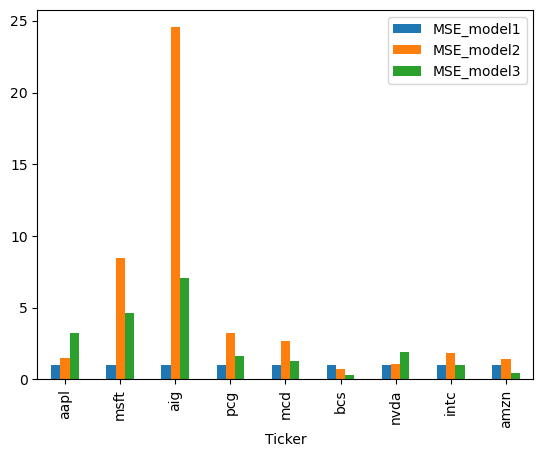

In [35]:
mse_merged.set_index('Ticker').plot(kind='bar')

Majority of 2nd and 3rd models' MSE is higher than the 1st model's MSE. Simplicity wins. That is simplicity of RNN in comparison to LSTM as well. Because 3rd model is the univariate model of LSTM. 